In [1]:
import matplotlib
import pickle
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import numpy as np
import pickle
from torch.optim import lr_scheduler
from os.path import exists
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import random
torch.manual_seed(1)
random.seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading

In [2]:
def calculate_rms(waveforms):
    reshape=False
    if len(waveforms.shape) == 4:
        waveforms = waveforms.reshape(-1, 16, 1056)
        reshape = True
    return waveforms.square().mean(axis=len(waveforms.shape) - 1).sqrt()

def get_max_rms(rms_waveforms):
    return rms_waveforms.max(axis=1)[0]

combined_waveforms, combined_positions = torch.load("final_results/truck_final_combined_data.pt")
# cv_groups, test_set = torch.load("final_results/truck_combined_data_indexes.pt")

test_set_bins = torch.load("final_results/test_set_bins.pt")
train_set_indexes_7_sorted = torch.load("final_results/train_set_indexes_7_sorted.pt")
combined_rms_waveforms = calculate_rms(combined_waveforms)
indexes = train_set_indexes_7_sorted
print(len(indexes))
torch.manual_seed(1)
random.seed(1)

training_waveforms = combined_waveforms[indexes]
training_positions = combined_positions[indexes]

num = 3220
data = [i for i in range(num)]
split_size = 30
num_splits = num // split_size
num_splits_per_group = num_splits // 4
print(num_splits, num_splits_per_group)
num_used_splits = num_splits_per_group * 4
perm = torch.randperm(num_used_splits)
cv_groups = []
for i in range(4):
    group = []
    for split in perm[num_splits_per_group*i: (num_splits_per_group*i)+num_splits_per_group]:
        group.extend([j for j in range(split_size*split, (split_size*split)+split_size)])
    group.extend([j for j in range((num // 120 * 120)+(25*i), (num // 120 * 120)+(25*i)+25)])
    print(len(group))
    cv_groups.append(torch.tensor(group))
total_test_set = torch.hstack(test_set_bins)
print("total test set", total_test_set.shape)

train_valid_test_sets = []
for valid in cv_groups:
    train = torch.hstack([group for group in cv_groups if group is not valid])
    X_train = calculate_rms(training_waveforms[train])
    Y_train = training_positions[train]
    X_valid = calculate_rms(training_waveforms[valid])
    Y_valid = training_positions[valid]
    X_test = calculate_rms(combined_waveforms[total_test_set])
    Y_test = combined_positions[total_test_set]
    print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape)
    train_valid_test_sets.append([X_train, Y_train, X_valid, Y_valid, X_test, Y_test])
    print(int(Y_valid[0, 0].item()), int(Y_valid[0, 1].item()))
print(train_valid_test_sets[3][3][0])

3220
107 26
805
805
805
805
total test set torch.Size([1150])
torch.Size([2415, 16]) torch.Size([2415, 2]) torch.Size([805, 16]) torch.Size([805, 2]) torch.Size([1150, 16]) torch.Size([1150, 2])
471 322
torch.Size([2415, 16]) torch.Size([2415, 2]) torch.Size([805, 16]) torch.Size([805, 2]) torch.Size([1150, 16]) torch.Size([1150, 2])
422 187
torch.Size([2415, 16]) torch.Size([2415, 2]) torch.Size([805, 16]) torch.Size([805, 2]) torch.Size([1150, 16]) torch.Size([1150, 2])
145 201
torch.Size([2415, 16]) torch.Size([2415, 2]) torch.Size([805, 16]) torch.Size([805, 2]) torch.Size([1150, 16]) torch.Size([1150, 2])
246 115
tensor([246.3203, 115.5686])


# Final training test set

In [3]:
print((test_set_bins[0]))
X_test_sets = [calculate_rms(combined_waveforms[bin_indexes]) for bin_indexes in test_set_bins]
Y_test_sets = [combined_positions[bin_indexes] for bin_indexes in test_set_bins]

tensor([3657, 3658, 3668, 3669, 3670, 3671, 3672, 3675, 3710, 3711, 3714, 3715,
        3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733,
        3734, 3746, 3749, 3788, 3789, 3899, 3900, 3902, 3903, 3904, 3907, 3908,
        4031, 4134, 4135, 4137, 4140, 4141, 4266, 4267, 4268, 4632, 4633, 4634,
        4639, 4824, 4825, 4826, 4827, 4832, 4835, 4836, 4837, 4838, 4839, 4840,
        4841, 4842, 5023, 5030, 5031, 5032, 5076, 5093, 5153, 5154, 5155, 5156,
        5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168,
        5169, 5170, 5171, 5489, 5490, 5491, 5493, 5494, 5495, 5496, 5497, 5498,
        5546, 5547, 5550, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568,
        5569, 5572, 5586, 5587, 5588, 5590, 5651])


In [4]:
print(len(Y_test_sets[9]))

115


# Model Class and Training

In [5]:
def squared_loss(a, b):
    return (((a-b)**2)).sum(axis=1).mean()

def mae_loss(a, b):
    return (((a-b)**2)).sum(axis=1).sqrt().mean()

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes=None, sigmoid_vars=[700, 500], use_relu=True):
        super(NeuralNetwork, self).__init__()
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.use_relu = use_relu
        if layer_sizes is None:
            layer_sizes = [16, 128, 128, 128, 2]
            
        self.linear_layers = nn.ModuleList([])
        for i in range(1, len(layer_sizes)):
            self.linear_layers.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
        
        self.relu = nn.ReLU()
        if sigmoid_vars is not None:
            self.sigmoid = nn.Sigmoid()
            self.sigmoid_vars = torch.tensor(sigmoid_vars).float().cuda()
        else:
            self.sigmoid_vars = None

    def forward(self, x):
        for i, linear_layer in enumerate(self.linear_layers):
            x = linear_layer(x)
            if i != len(self.linear_layers) - 1 and self.use_relu:
                x = self.relu(x)

        if self.sigmoid_vars is not None:
            x = self.sigmoid(x) * self.sigmoid_vars
        return x

def train_model(model, data, batch_size=32, epochs=200, parameters="", saving="use_saved", 
                shuffle_data=True, save=False, verbose=True, 
                validation_losses=None, train_losses = None, lr=0.01, final=False):
    torch.manual_seed(1)
    random.seed(1)
    print(data[3][0])
    model=model.cuda()
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [i.cuda() for i in data]
    
    
    if validation_losses is None:
        validation_losses = []
        train_losses = []
    sig = "sig" if model.sigmoid_vars is not None else ""
    relu = "relu" if model.use_relu else ""
    # print(sch)
    parameters = f"models_rms/b{batch_size},e{epochs},{model.layer_sizes},{sig},{relu},LR{str(lr)}{(int(Y_val[0, 0].item()), int(Y_val[0, 1].item()))}" + parameters
    print(parameters)
    if saving == "delete":
        os.remove(parameters + "_model.pt")
        os.remove(parameters + "_loss.pt")
        return
    if exists(parameters + "_loss.pt") and saving=="use_saved":
        model.load_state_dict(torch.load(parameters + "_model.pt"))
        train_losses, validation_losses, lowest_train_loss, lowest_valid_loss = torch.load(parameters + "_loss.pt")
        with torch.no_grad():
            test_loss = mae_loss(model(X_test), Y_test)
        print("Using saved model", str(lr), str(model.layer_sizes).ljust(20), str(lowest_train_loss).ljust(8), str(lowest_valid_loss).ljust(8), str(int(test_loss)).ljust(8))
        return model, train_losses, validation_losses, parameters[7:], lowest_train_loss, lowest_valid_loss, test_loss
    else:
        print(parameters)
        
    if shuffle_data:
        perm=torch.randperm(len(X_train))
        X_train, Y_train = X_train[perm], Y_train[perm]

    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.997)
    
    lowest_valid_loss = torch.tensor(10000000)
    # epochs = 0
    # lr_change_epochs = []
    # for lr, epoch_num in sch:
    #     lr_change_epochs.append(epochs)
    #     epochs += epoch_num
    pbar = tqdm(range(epochs), ncols=125)
    num_times_saved=0
    loss = nn.MSELoss()
    for epoch in pbar:
        # if epoch in lr_change_epochs:
        #     new_lr = sch[lr_change_epochs.index(epoch)][0]
        #     for g in optimizer.param_groups:
        #         g['lr'] = new_lr
        for batch in range(len(X_train) // batch_size):
            model.train()
            optimizer.zero_grad()
            outputs_train = model(X_train[batch_size * batch: batch_size * (batch + 1)])
            
            batch_train_loss = loss(outputs_train, Y_train[batch_size * batch: batch_size * (batch + 1)])
            batch_train_loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            train_loss = mae_loss(model(X_train), Y_train)
            validation_loss = mae_loss(model(X_val), Y_val)
            
        if validation_loss < lowest_valid_loss:
            with torch.no_grad():
                test_loss = mae_loss(model(X_test), Y_test)
            lowest_valid_loss = validation_loss
            lowest_train_loss = train_loss
            if "sav" in saving:
                torch.save(model.state_dict(), parameters + "_model.pt")
                num_times_saved += 1
            torch.save(model.state_dict(), "temp_model_8.pt")
        validation_losses.append(validation_loss.detach().cpu().item())
        train_losses.append(train_loss.detach().cpu().item())
        scheduler.step()
        pbar.set_description(str(epoch) +" Tr:"+ str(round(train_loss.item(), 2))+" V:"+ 
                             str(round(validation_loss.item(), 2))+" Te:"+ str(round(test_loss.item(), 2)) + " "+
                             str(num_times_saved) + " "+str(round(lowest_valid_loss.item(), 4)) + " "+str(scheduler.get_last_lr()))
    if "sav" in saving:
        torch.save((train_losses, validation_losses, lowest_train_loss, lowest_valid_loss), parameters + "_loss.pt")
    model.load_state_dict(torch.load("temp_model_8.pt"))
    with torch.no_grad():
        test_loss = mae_loss(model(X_test), Y_test)

    return model, train_losses, validation_losses, parameters[7:], lowest_train_loss, lowest_valid_loss, test_loss

def plot(results, title="Plot of Train and Validation Loss, "):
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot(results[1], label="Train Loss")
    plt.plot(results[2], label="Validation Loss")
    param = results[3]
    plt.title(title + param)
    plt.legend()
    plt.show()

# Figure out what the best model is

In [6]:
def test_model(model, train_valid_test_sets, add_to_title="", num_to_test=4, lr=0.01, epochs=1000):
    averaged_train_loss = 0.0
    averaged_valid_loss = 0.0
    averaged_test_loss = 0.0
    torch.save(model, "temp_model_54.pt")
    torch.save(model.state_dict(), "temp_model_55.pt")

    for i in range(num_to_test):
        model = torch.load("temp_model_54.pt")
        model.load_state_dict(torch.load("temp_model_55.pt"))

        results = train_model(model.cuda(), train_valid_test_sets[i], batch_size=32, lr=lr, epochs=epochs, parameters=",eLR")
        model, train_losses, validation_losses, parameter_parts, lowest_train_loss, lowest_valid_loss, test_loss = results
        
        averaged_train_loss += lowest_train_loss / num_to_test
        averaged_valid_loss += lowest_valid_loss / num_to_test
        averaged_test_loss += test_loss / num_to_test
        
        plot(results, title=f"{str(model.layer_sizes)} Cross Validation Set {i}{add_to_title}")
    print(averaged_train_loss, averaged_valid_loss, averaged_test_loss)

# 16, 16, 16

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(471, 322),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(471, 322),eLR


1999 Tr:52.19 V:57.81 Te:79.5 704 57.8109 [2.456499178934972e-05]: 100%|█████████████████| 2000/2000 [02:14<00:00, 14.85it/s]


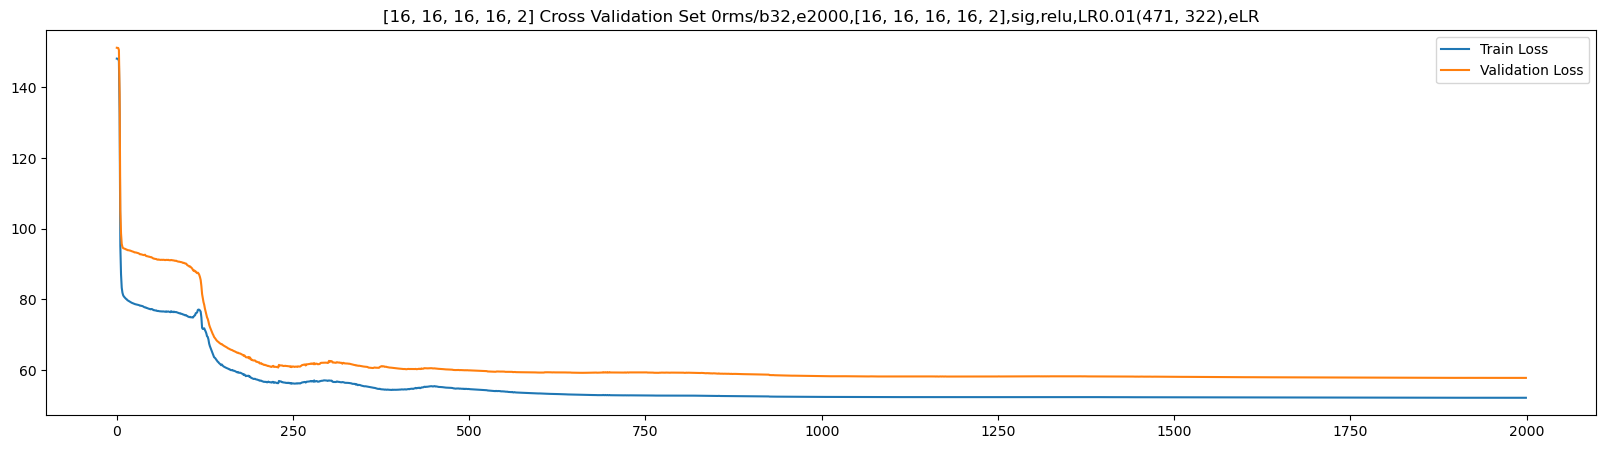

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(422, 187),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(422, 187),eLR


1999 Tr:51.07 V:54.43 Te:76.98 249 53.9145 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:13<00:00, 14.94it/s]


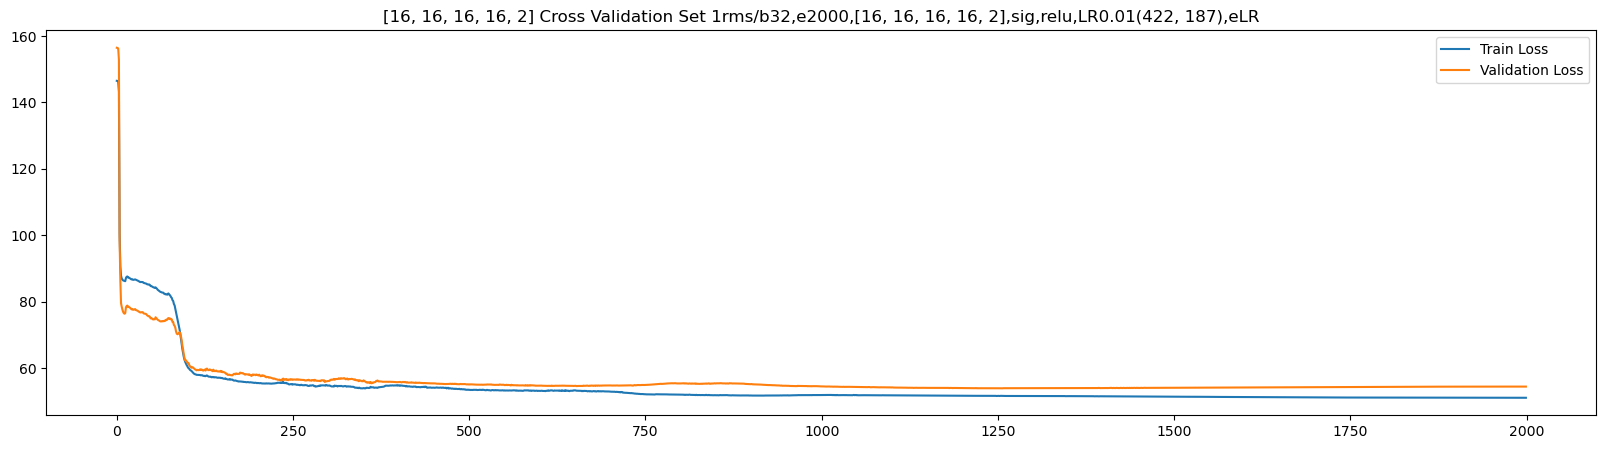

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(145, 201),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(145, 201),eLR


1999 Tr:146.89 V:156.07 Te:156.56 3 154.2592 [2.456499178934972e-05]: 100%|██████████████| 2000/2000 [02:13<00:00, 15.00it/s]


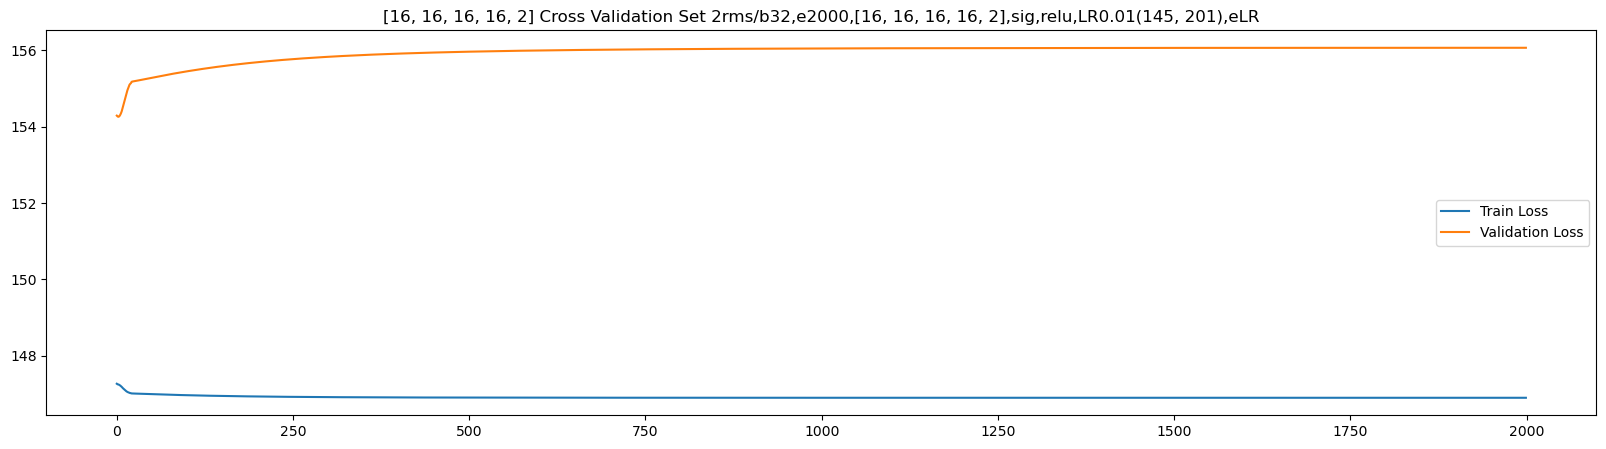

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(246, 115),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.01(246, 115),eLR


1999 Tr:51.35 V:58.77 Te:82.87 121 56.947 [2.456499178934972e-05]: 100%|█████████████████| 2000/2000 [02:12<00:00, 15.09it/s]


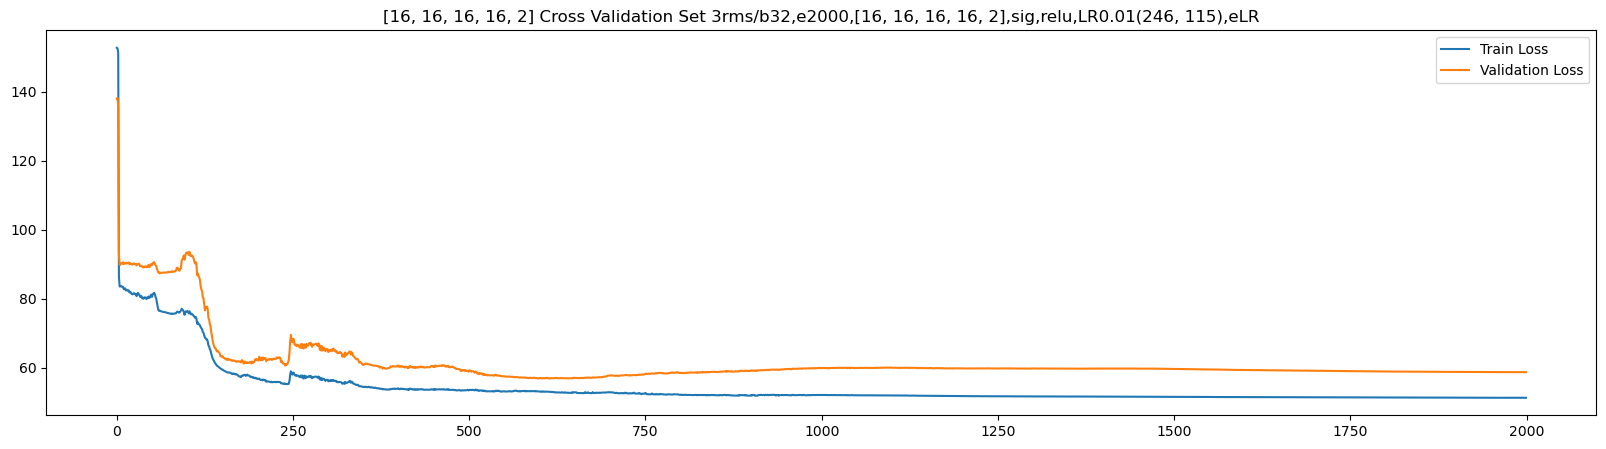

tensor(76.0426, device='cuda:0') tensor(80.7329, device='cuda:0') tensor(98.9788, device='cuda:0')


In [70]:
model = test_model(NeuralNetwork([16 ,16, 16, 16, 2]), train_valid_test_sets, 
                   lr=0.01, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(471, 322),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(471, 322),eLR


1999 Tr:75.48 V:89.91 Te:111.17 518 89.8636 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:14<00:00, 14.87it/s]


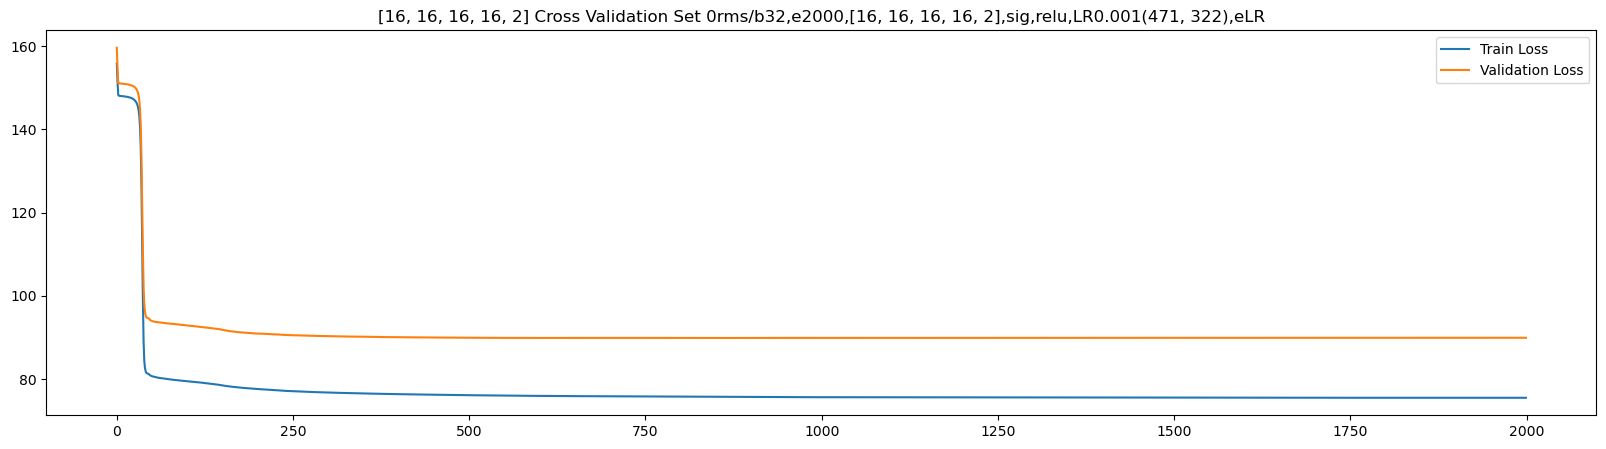

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(422, 187),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(422, 187),eLR


1999 Tr:81.95 V:72.75 Te:111.19 288 72.7514 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:15<00:00, 14.81it/s]


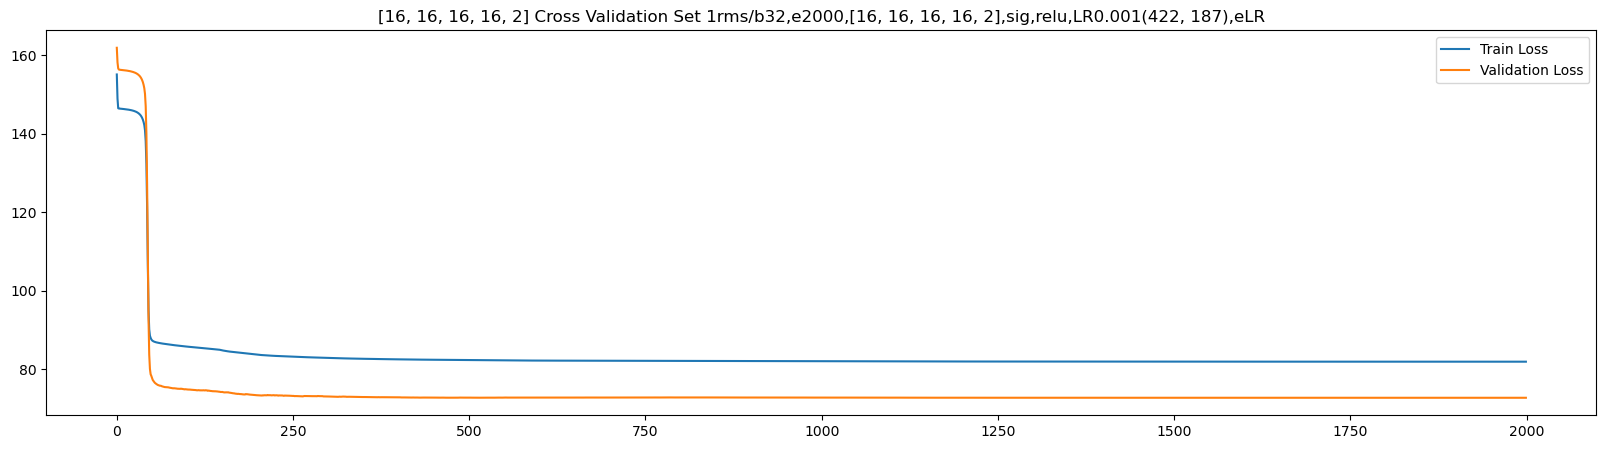

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(145, 201),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(145, 201),eLR


1999 Tr:81.09 V:78.97 Te:109.28 196 78.5157 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:13<00:00, 15.03it/s]


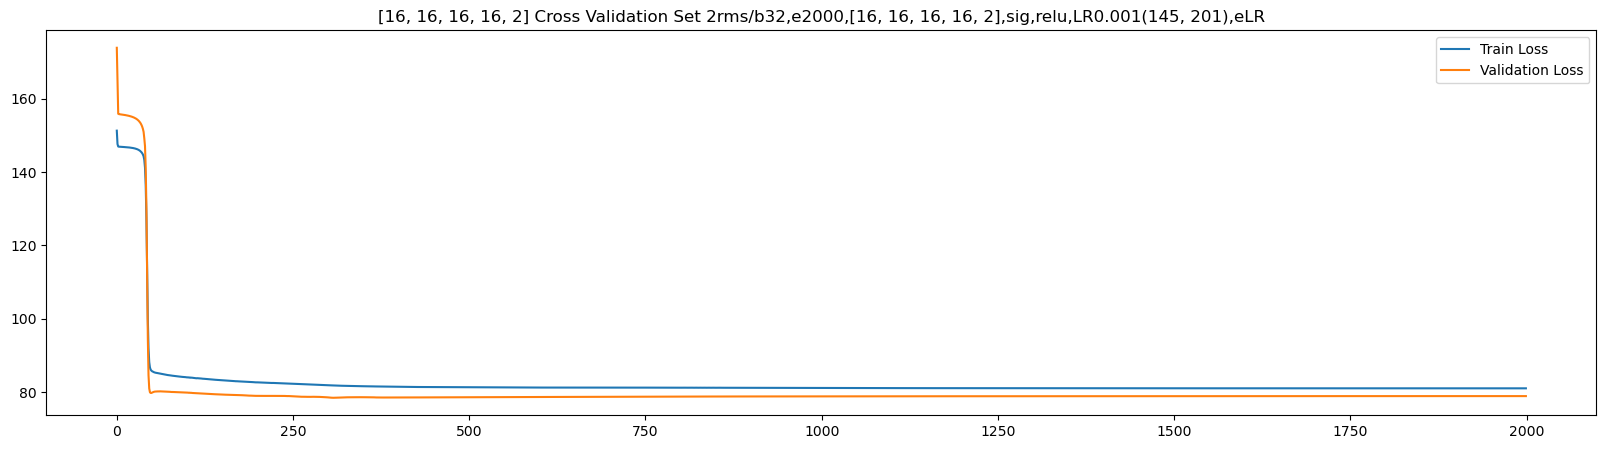

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(246, 115),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.001(246, 115),eLR


1999 Tr:75.51 V:87.92 Te:109.24 157 87.8547 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:13<00:00, 15.03it/s]


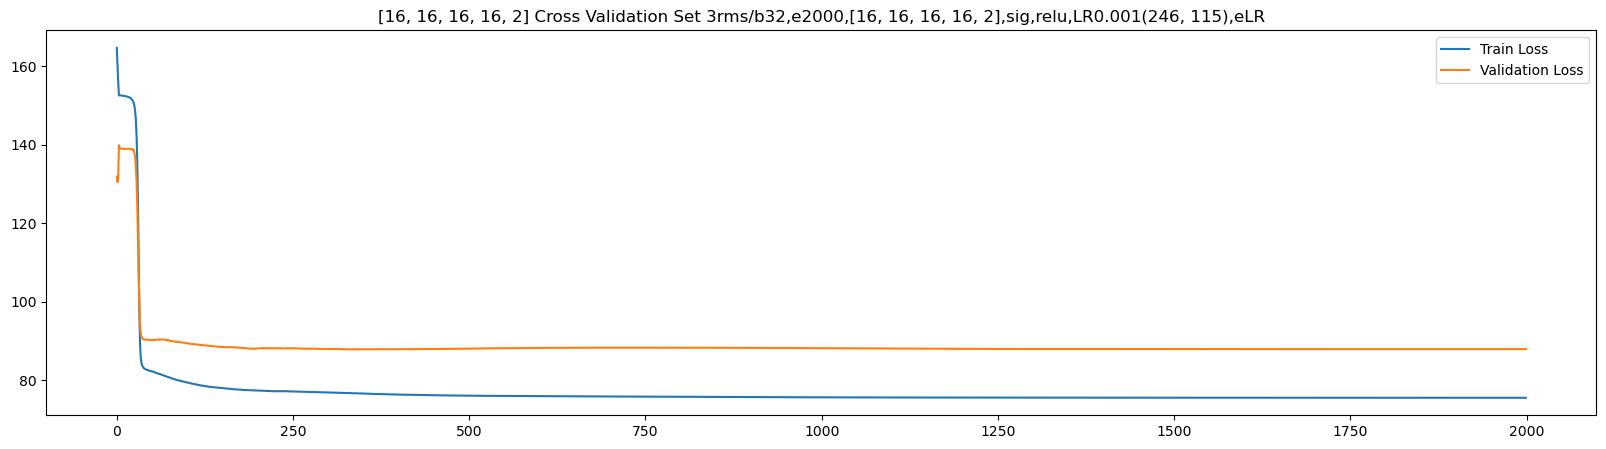

tensor(79.0201, device='cuda:0') tensor(82.2464, device='cuda:0') tensor(110.2187, device='cuda:0')


In [71]:
model = test_model(NeuralNetwork([16 ,16, 16, 16, 2]), train_valid_test_sets, 
                   lr=0.001, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(471, 322),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(471, 322),eLR


1999 Tr:148.14 V:151.1 Te:157.56 937 151.1011 [0.0002456499178934952]: 100%|█████████████| 2000/2000 [02:15<00:00, 14.79it/s]


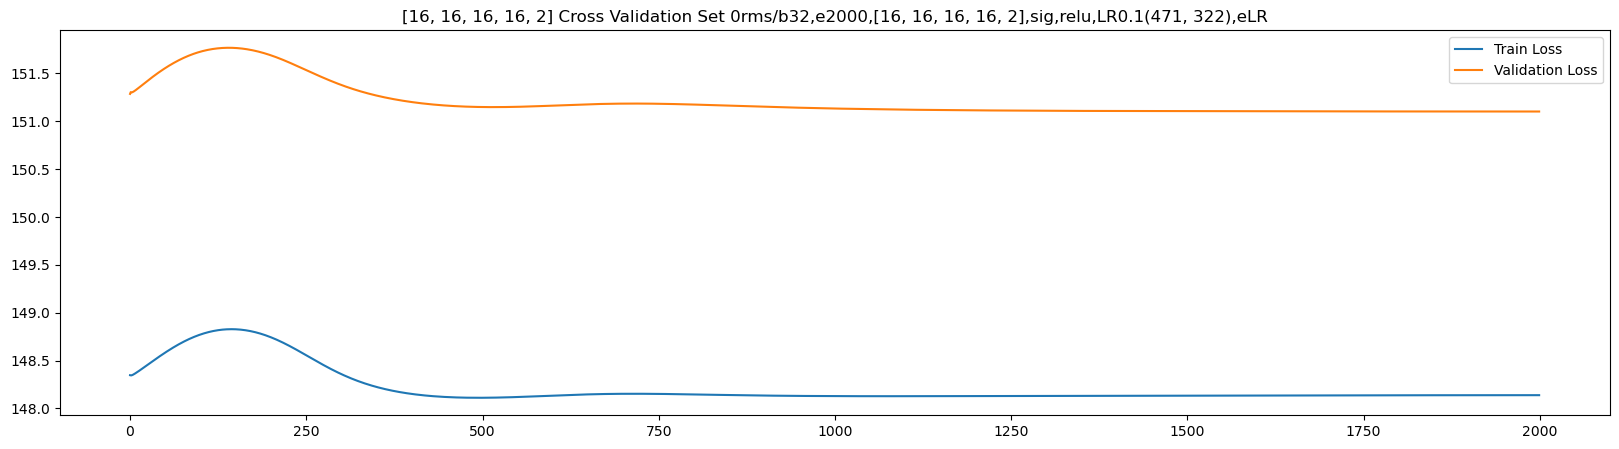

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(422, 187),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(422, 187),eLR


1999 Tr:146.52 V:156.5 Te:156.96 679 156.3914 [0.0002456499178934952]: 100%|█████████████| 2000/2000 [02:15<00:00, 14.73it/s]


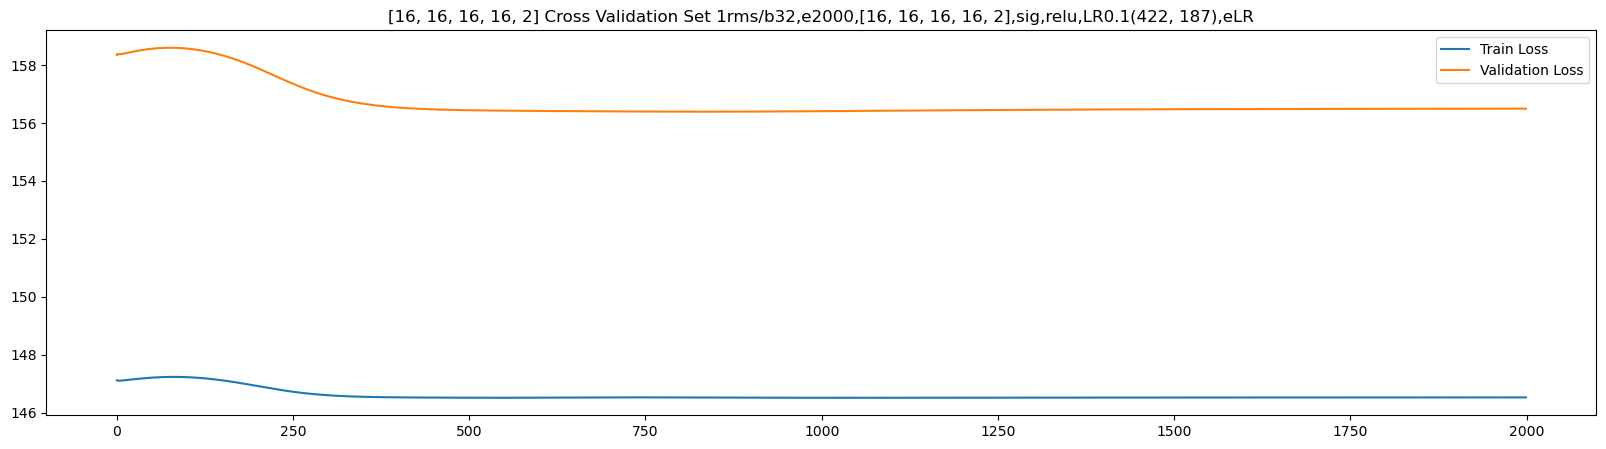

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(145, 201),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(145, 201),eLR


1999 Tr:146.89 V:156.06 Te:156.53 294 154.2977 [0.0002456499178934952]: 100%|████████████| 2000/2000 [02:13<00:00, 15.03it/s]


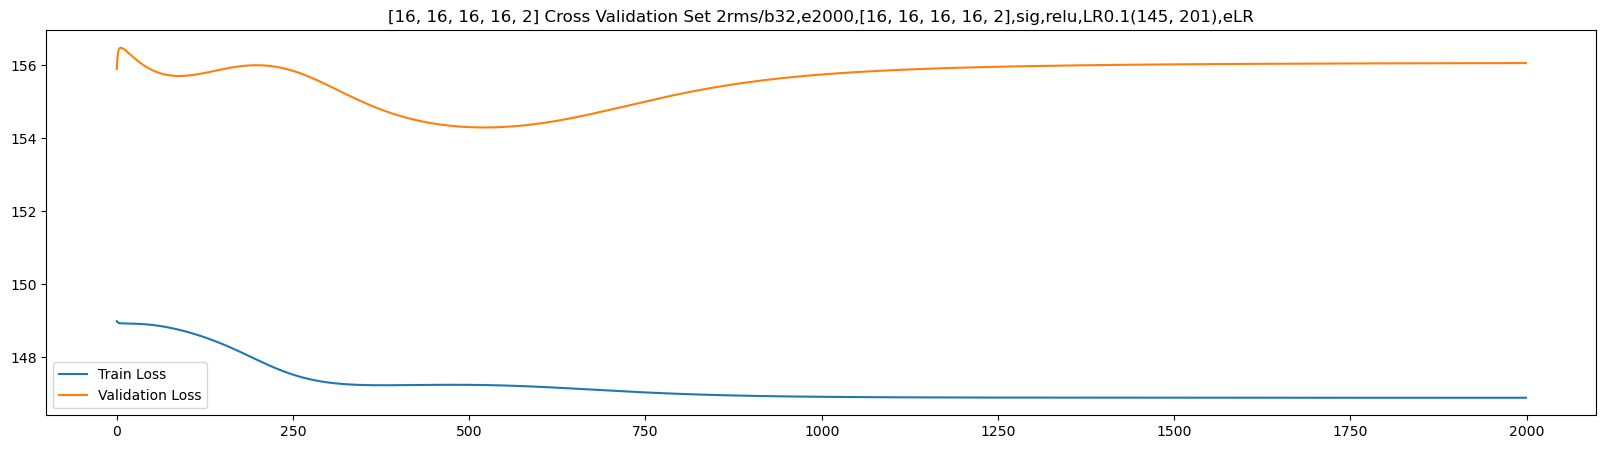

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(246, 115),eLR
models_rms/b32,e2000,[16, 16, 16, 16, 2],sig,relu,LR0.1(246, 115),eLR


1999 Tr:152.78 V:138.18 Te:157.58 8 135.6242 [0.0002456499178934952]: 100%|██████████████| 2000/2000 [02:13<00:00, 14.99it/s]


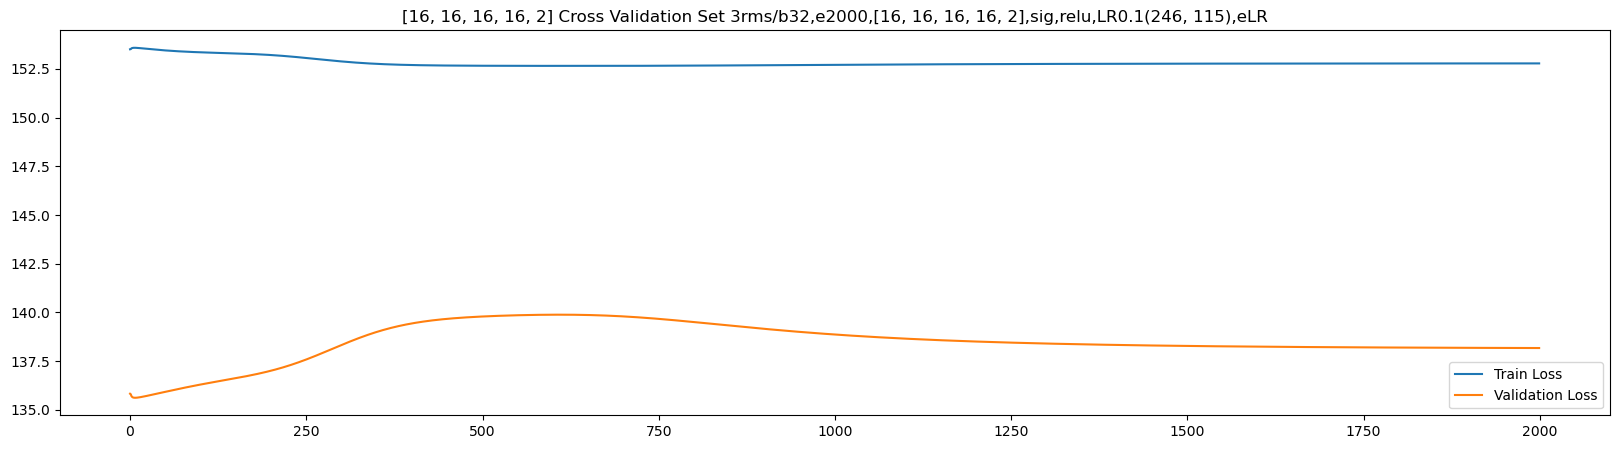

tensor(148.8698, device='cuda:0') tensor(149.3536, device='cuda:0') tensor(157.1556, device='cuda:0')


In [72]:
model = test_model(NeuralNetwork([16 ,16, 16, 16, 2]), train_valid_test_sets, 
                   lr=0.1, num_to_test=4, epochs=2000)

# 32, 32, 32

In [74]:
# model = test_model(NeuralNetwork([16 ,32, 32, 32, 2]), train_valid_test_sets, 
#                    lr=0.1, num_to_test=4, epochs=2000)
# Does not work

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(471, 322),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(471, 322),eLR


1999 Tr:47.77 V:55.65 Te:77.97 300 55.6445 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:12<00:00, 15.09it/s]


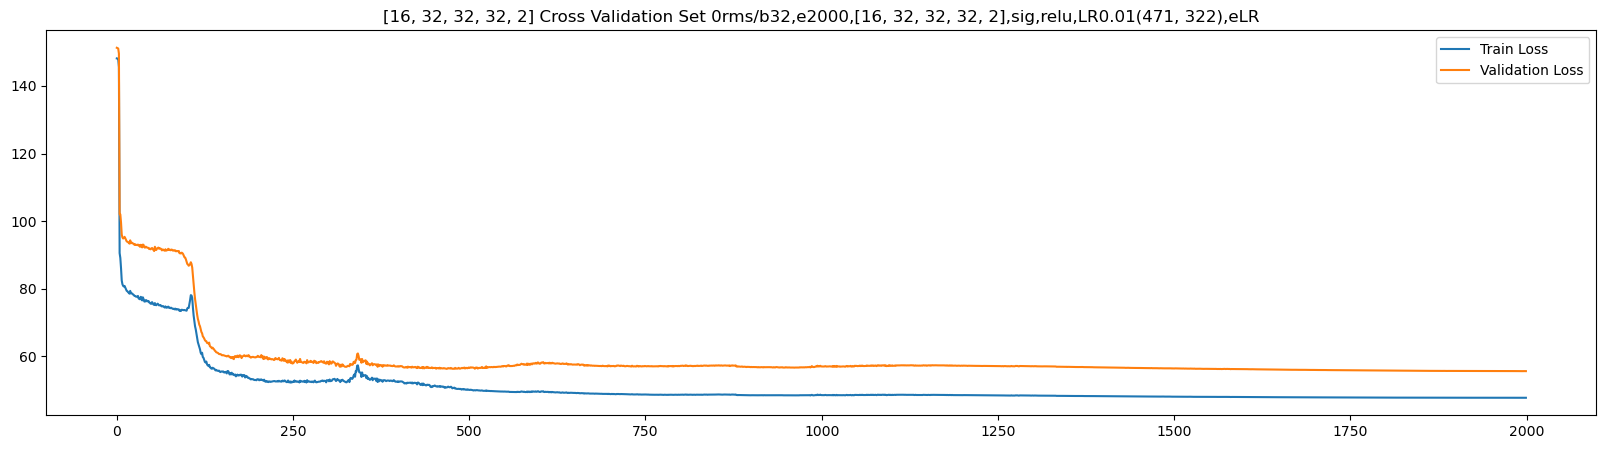

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(422, 187),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(422, 187),eLR


1999 Tr:49.36 V:53.61 Te:76.2 201 52.8835 [2.456499178934972e-05]: 100%|█████████████████| 2000/2000 [02:15<00:00, 14.76it/s]


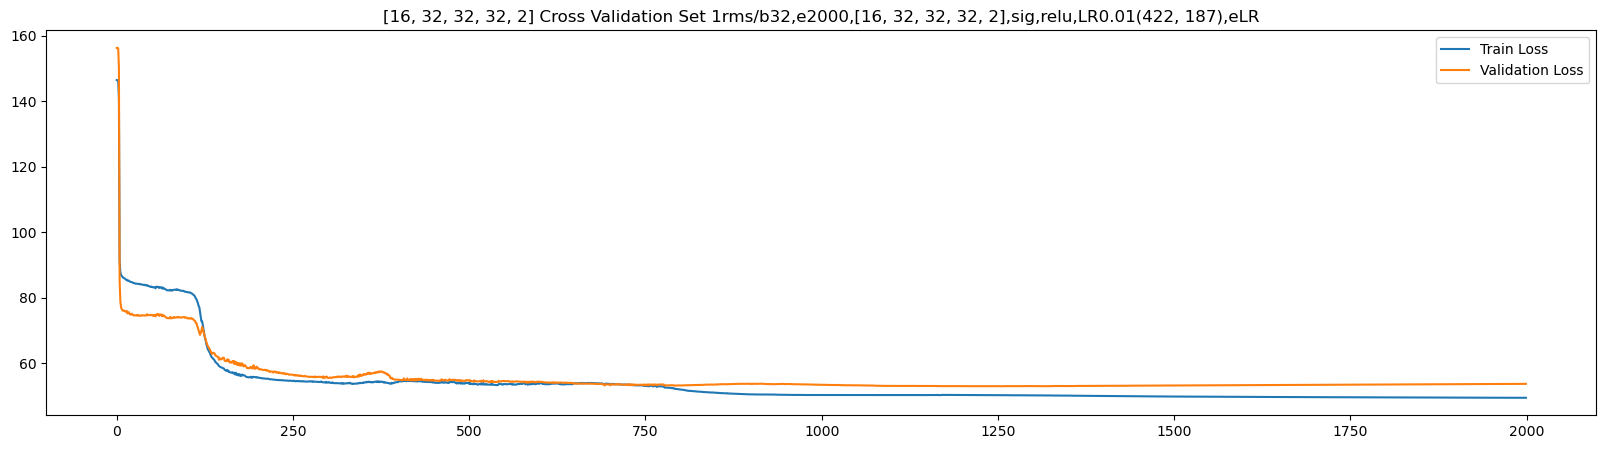

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(145, 201),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(145, 201),eLR


1999 Tr:49.77 V:54.81 Te:79.64 174 54.4282 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:10<00:00, 15.28it/s]


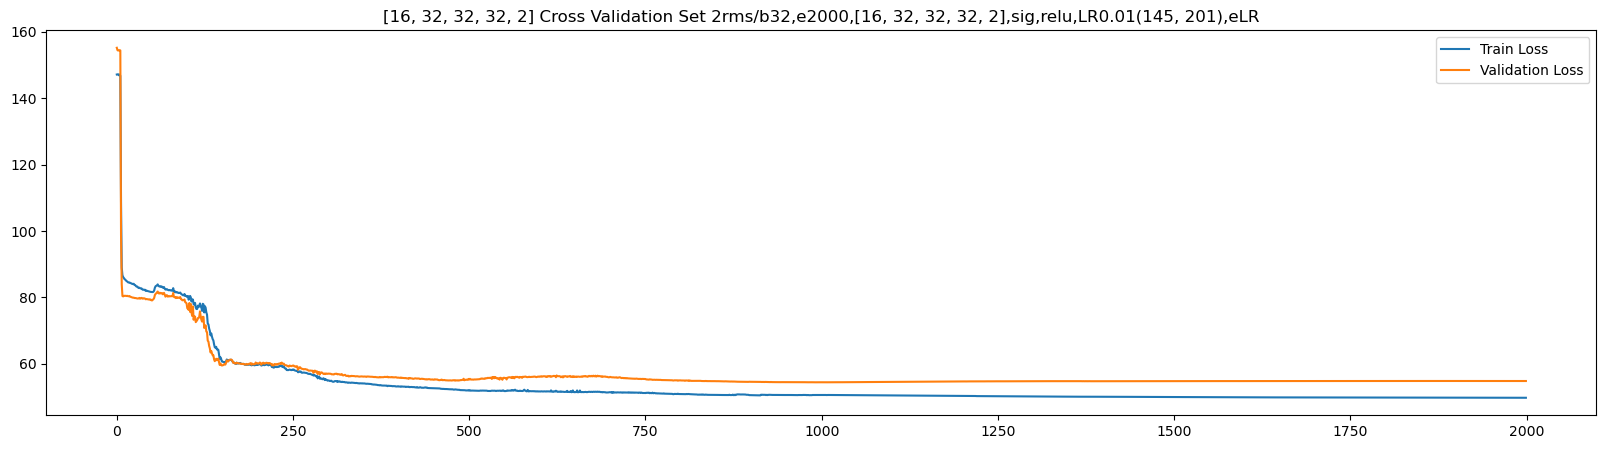

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(246, 115),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(246, 115),eLR


1999 Tr:48.4 V:54.52 Te:76.5 143 53.5552 [2.456499178934972e-05]: 100%|██████████████████| 2000/2000 [02:12<00:00, 15.13it/s]


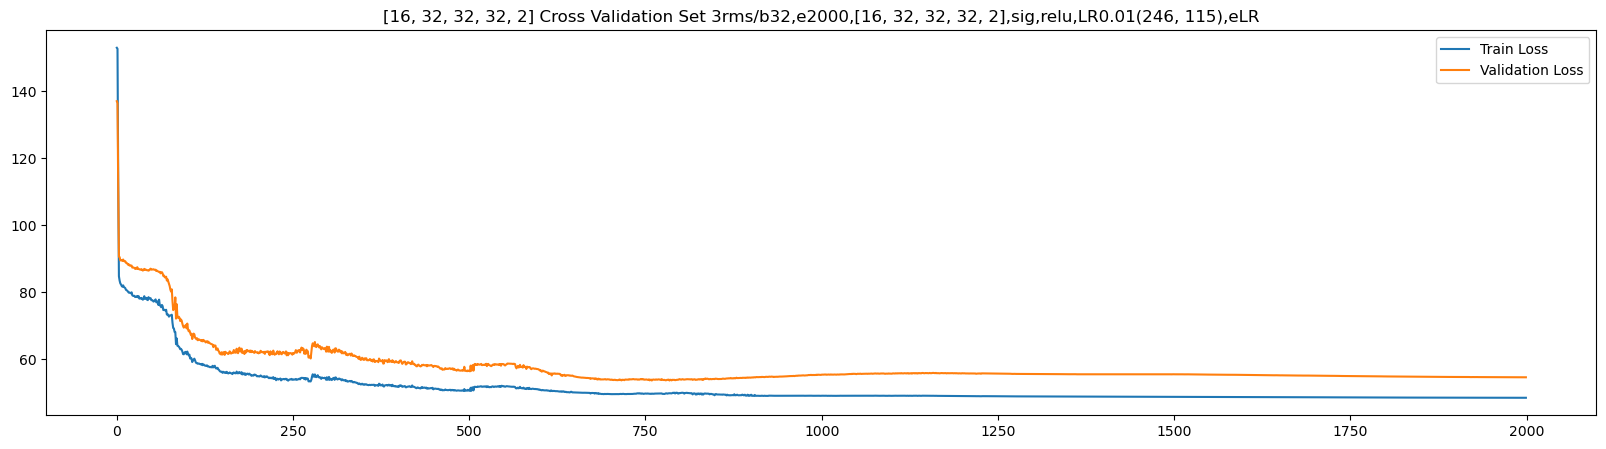

tensor(49.5292, device='cuda:0') tensor(54.1279, device='cuda:0') tensor(77.5781, device='cuda:0')


In [76]:
model = test_model(NeuralNetwork([16 ,32, 32, 32, 2]), train_valid_test_sets, 
                   lr=0.01, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(471, 322),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(471, 322),eLR


1999 Tr:56.43 V:65.23 Te:84.95 1643 65.2341 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:11<00:00, 15.16it/s]


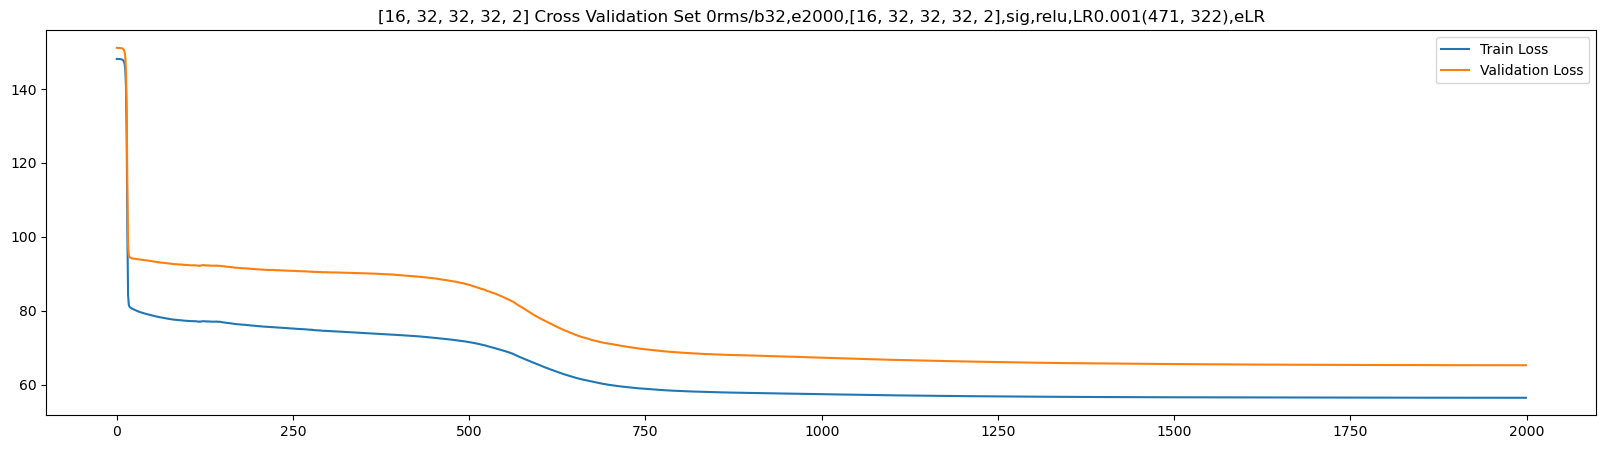

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(422, 187),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(422, 187),eLR


1999 Tr:55.96 V:57.08 Te:84.81 598 56.8974 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:10<00:00, 15.30it/s]


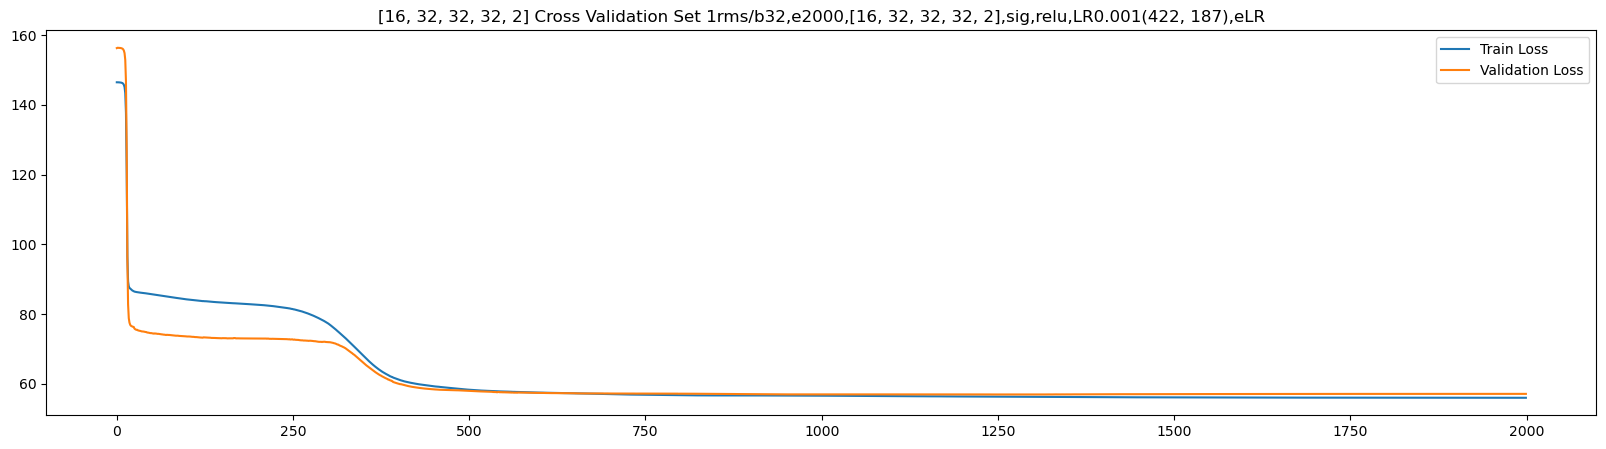

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(145, 201),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(145, 201),eLR


1999 Tr:58.48 V:56.88 Te:81.63 1230 56.8695 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:11<00:00, 15.19it/s]


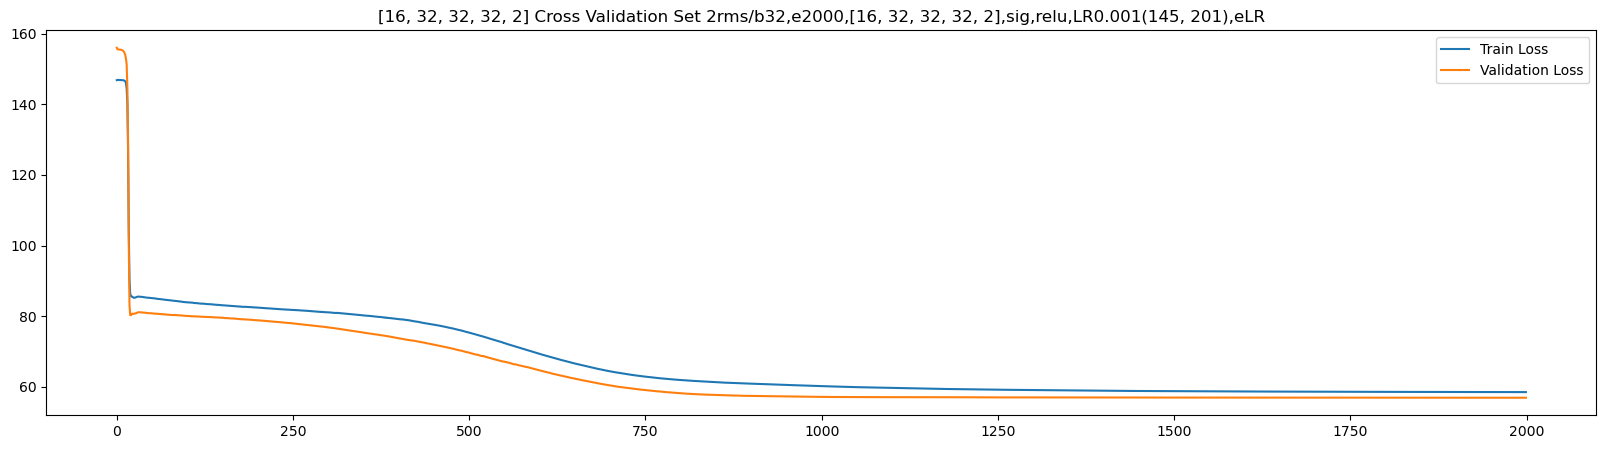

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(246, 115),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.001(246, 115),eLR


1999 Tr:60.5 V:65.91 Te:80.79 1532 65.9142 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:12<00:00, 15.09it/s]


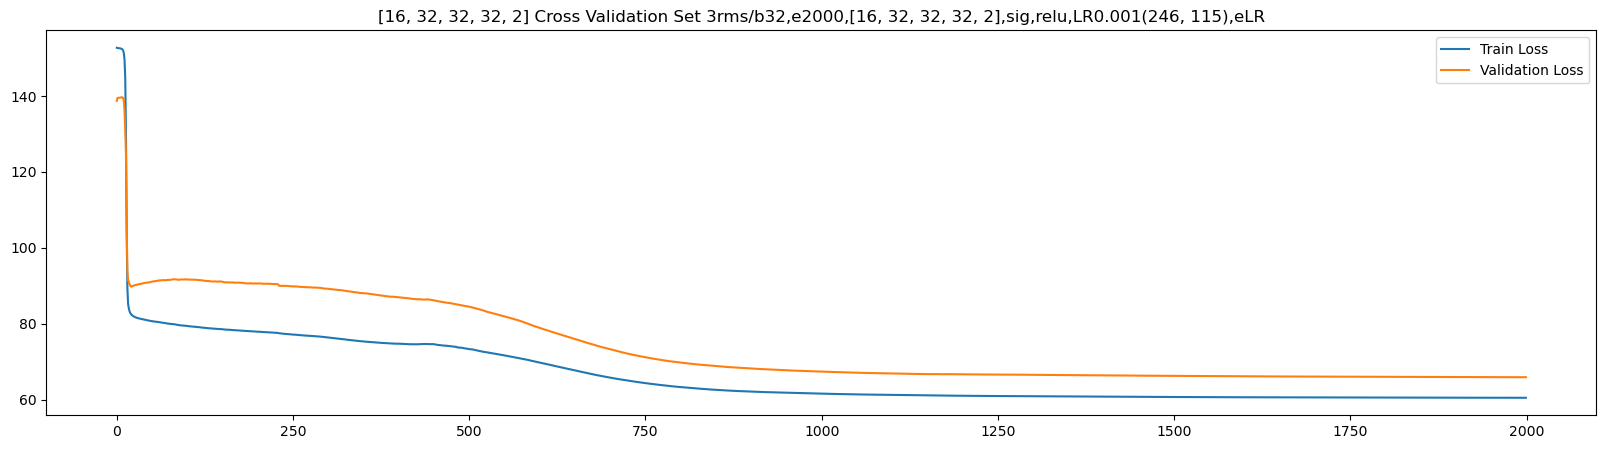

tensor(57.9306, device='cuda:0') tensor(61.2288, device='cuda:0') tensor(83.0467, device='cuda:0')


In [77]:
model = test_model(NeuralNetwork([16 ,32, 32, 32, 2]), train_valid_test_sets, 
                   lr=0.001, num_to_test=4, epochs=2000)

# 64 64 64

In [ ]:
# model = test_model(NeuralNetwork([16 ,64, 64, 64, 2]), train_valid_test_sets, 
#                    lr=0.1, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(471, 322),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(471, 322),eLR


1999 Tr:148.14 V:151.1 Te:157.47 3 151.0536 [2.456499178934972e-05]: 100%|███████████████| 2000/2000 [02:11<00:00, 15.25it/s]


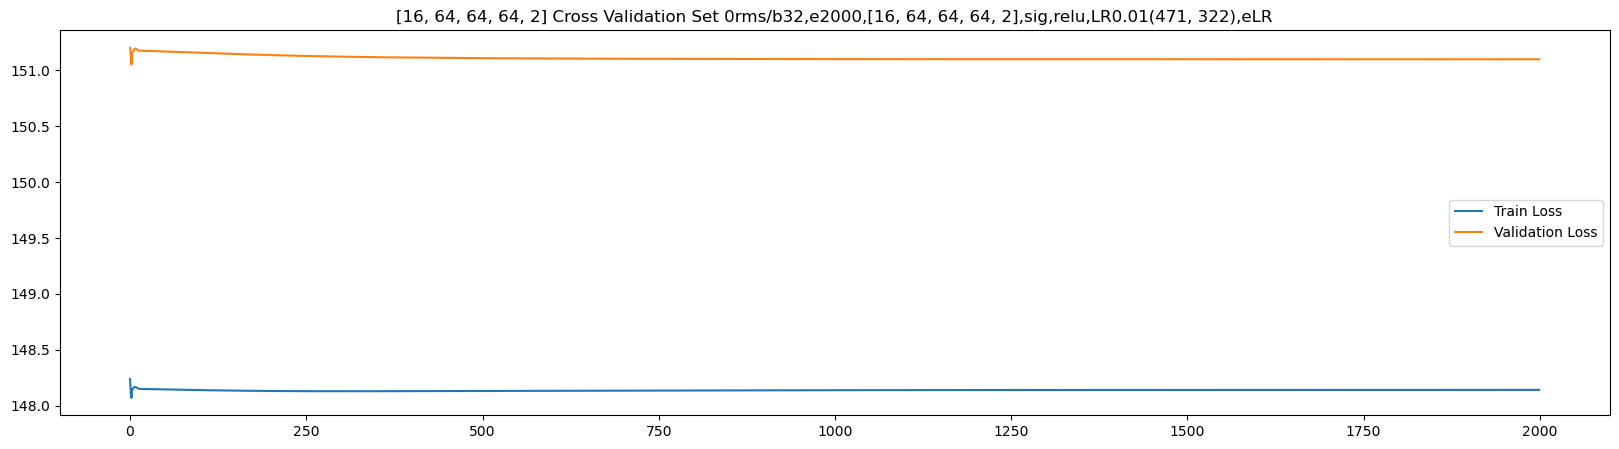

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(422, 187),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(422, 187),eLR


1999 Tr:46.08 V:54.3 Te:72.8 61 53.3273 [2.456499178934972e-05]: 100%|███████████████████| 2000/2000 [02:11<00:00, 15.16it/s]


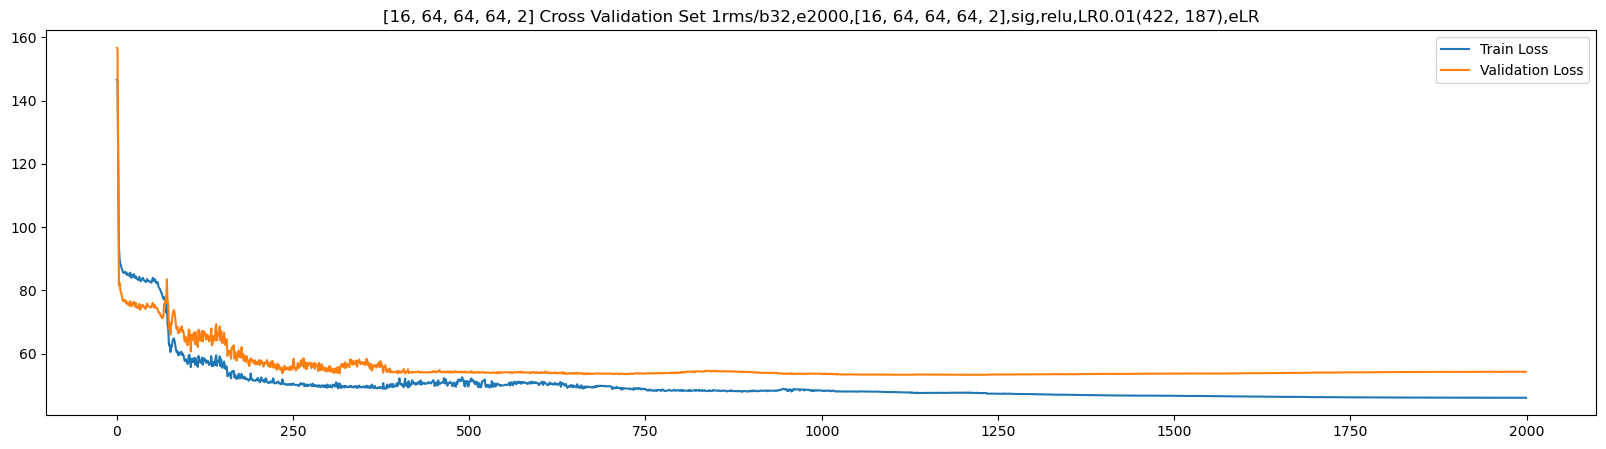

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(145, 201),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(145, 201),eLR


1999 Tr:48.82 V:54.41 Te:86.77 126 54.1465 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:11<00:00, 15.21it/s]


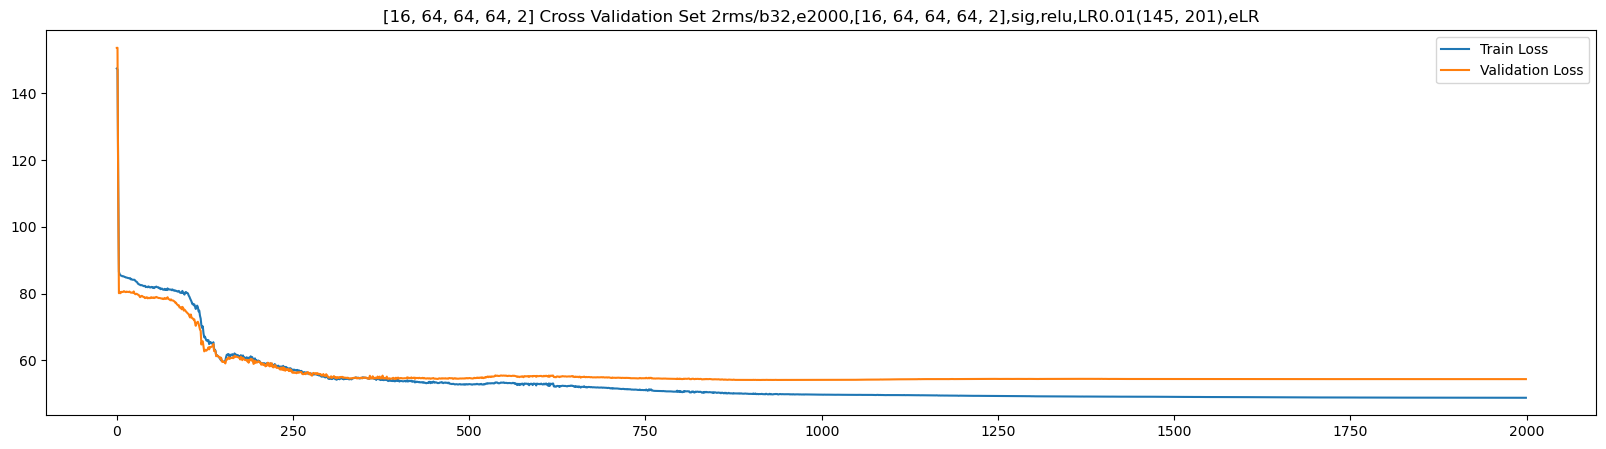

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(246, 115),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.01(246, 115),eLR


1999 Tr:46.89 V:55.45 Te:78.62 110 54.2369 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:12<00:00, 15.13it/s]


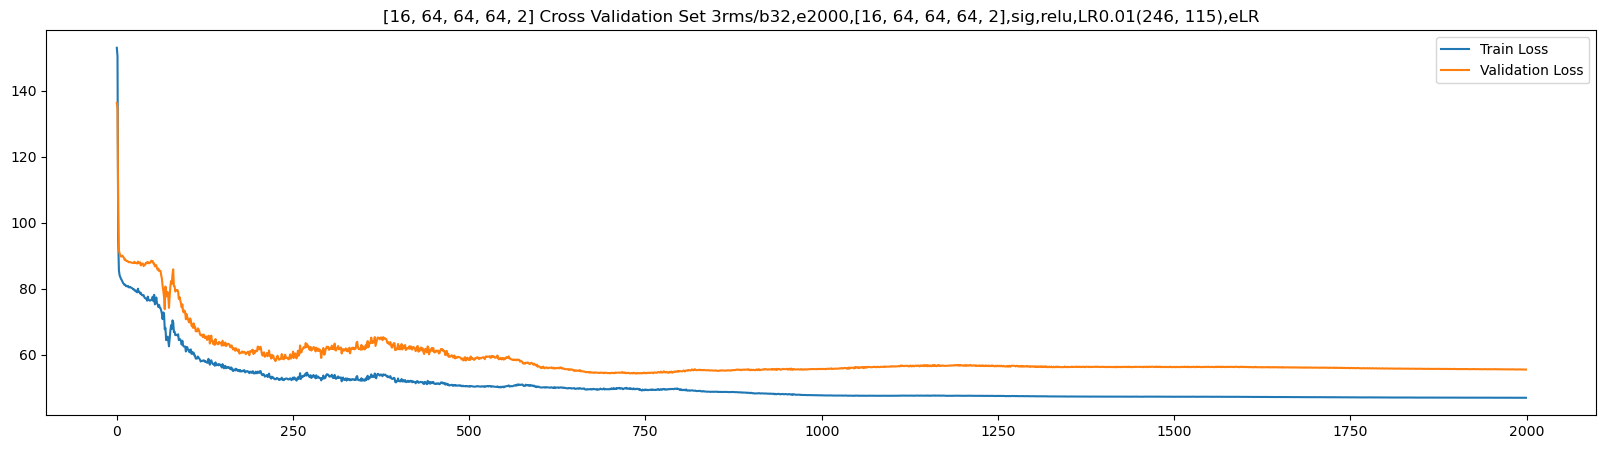

tensor(73.7870, device='cuda:0') tensor(78.1911, device='cuda:0') tensor(98.9143, device='cuda:0')


In [78]:
model = test_model(NeuralNetwork([16 ,64, 64, 64, 2]), train_valid_test_sets, 
                   lr=0.01, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(471, 322),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(471, 322),eLR


1999 Tr:52.98 V:59.68 Te:83.72 1325 59.6824 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:13<00:00, 14.98it/s]


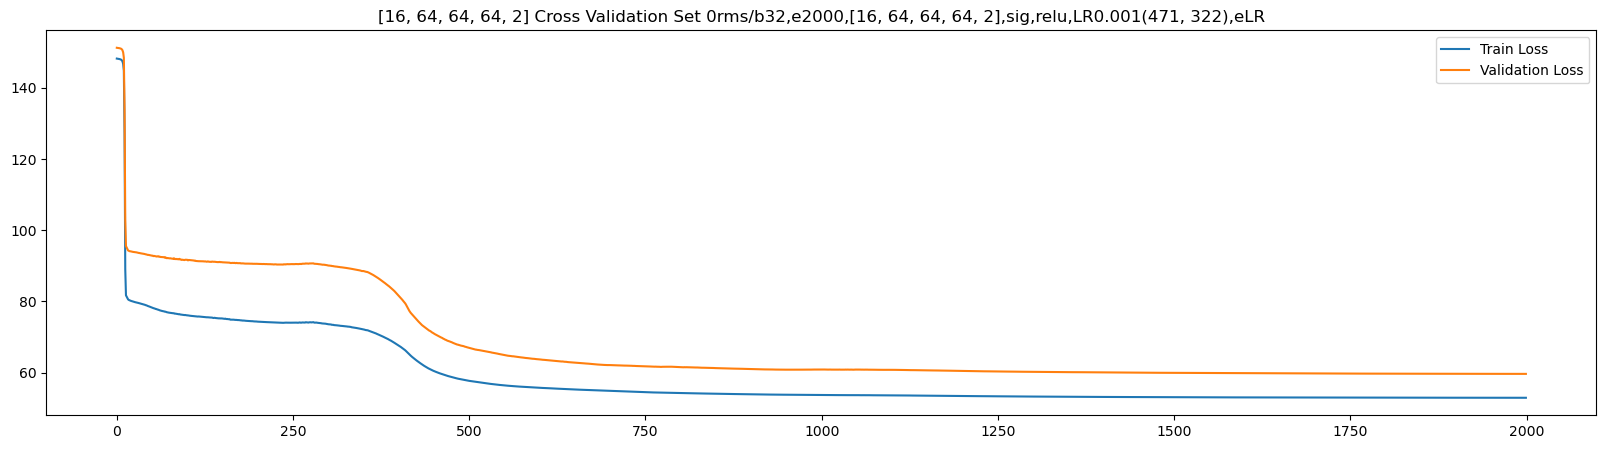

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(422, 187),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(422, 187),eLR


1999 Tr:52.06 V:55.86 Te:82.31 497 55.6556 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:13<00:00, 14.97it/s]


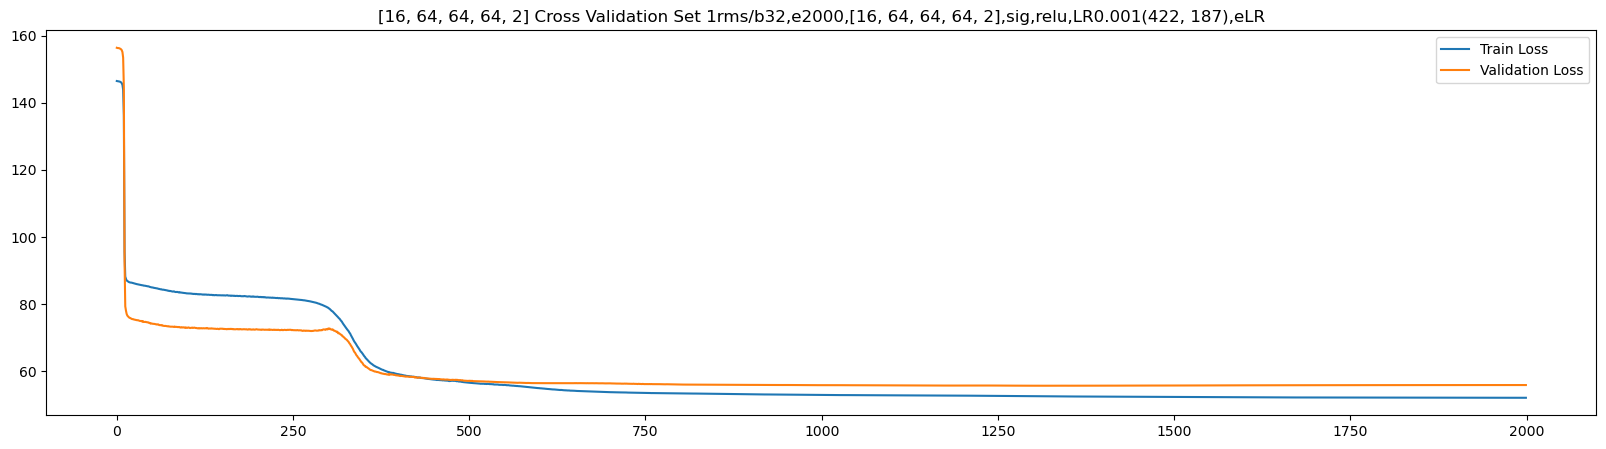

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(145, 201),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(145, 201),eLR


1999 Tr:52.52 V:56.12 Te:84.6 398 56.1158 [2.4564991789349756e-06]: 100%|████████████████| 2000/2000 [02:12<00:00, 15.10it/s]


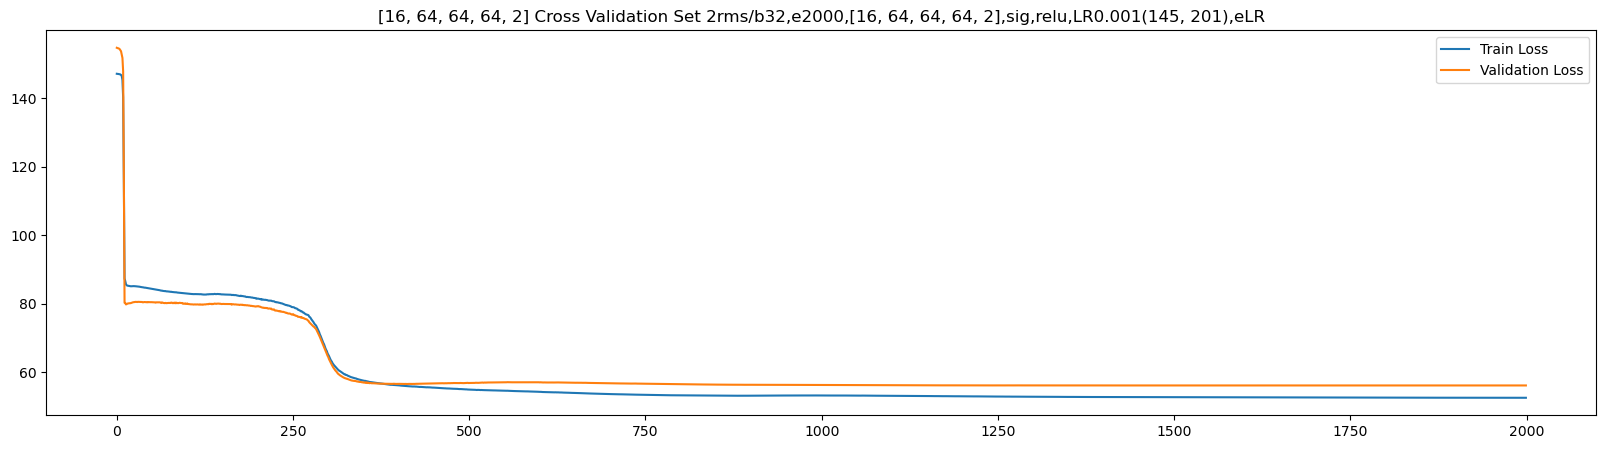

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(246, 115),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.001(246, 115),eLR


1999 Tr:52.92 V:58.08 Te:87.45 712 58.0749 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:13<00:00, 15.01it/s]


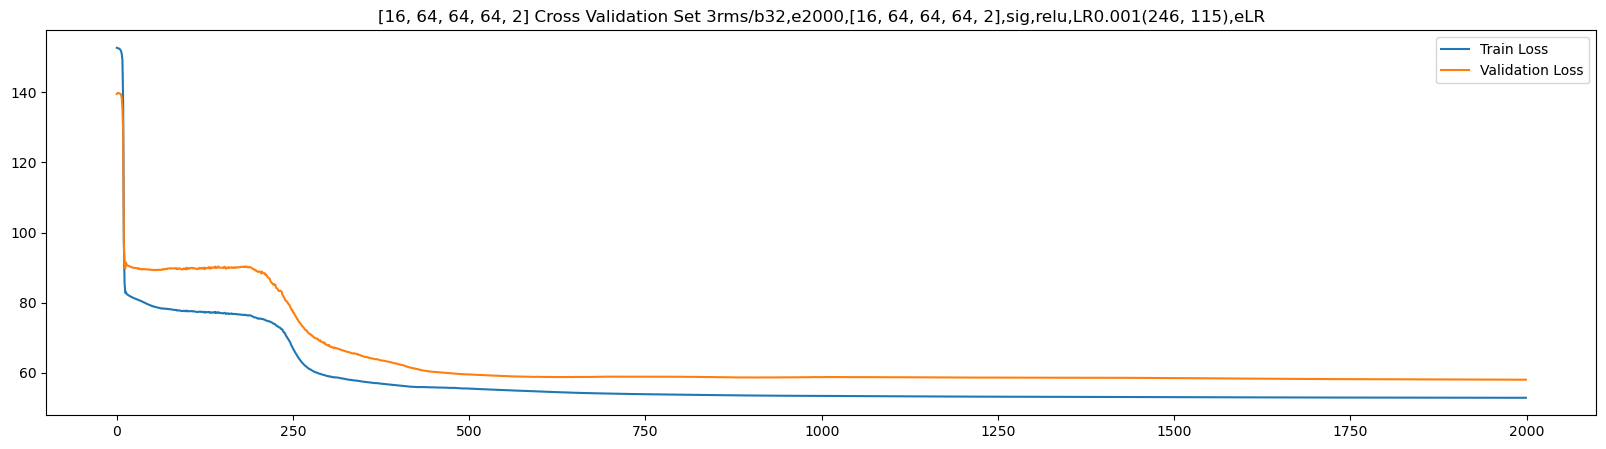

tensor(52.7738, device='cuda:0') tensor(57.3822, device='cuda:0') tensor(84.5203, device='cuda:0')


In [79]:
model = test_model(NeuralNetwork([16, 64, 64, 64, 2]), train_valid_test_sets, 
                   lr=0.001, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(471, 322),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(471, 322),eLR


1999 Tr:78.74 V:92.54 Te:105.05 1987 92.5447 [2.4564991789349657e-07]: 100%|█████████████| 2000/2000 [02:14<00:00, 14.90it/s]


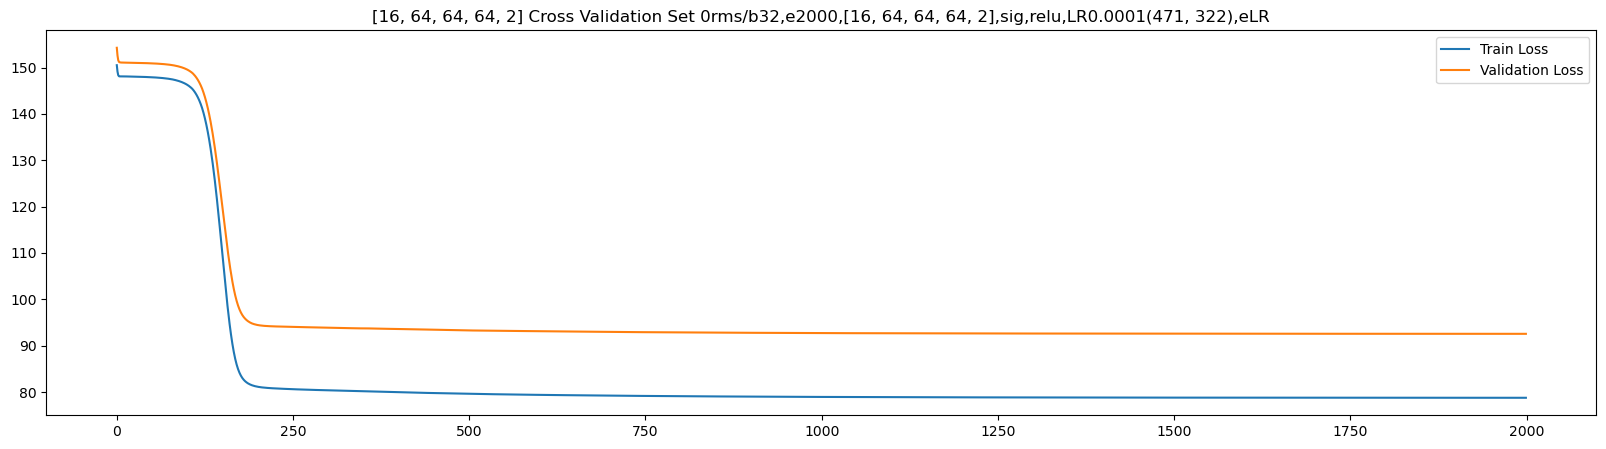

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(422, 187),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(422, 187),eLR


1999 Tr:84.98 V:74.51 Te:103.58 1520 74.5117 [2.4564991789349657e-07]: 100%|█████████████| 2000/2000 [02:14<00:00, 14.88it/s]


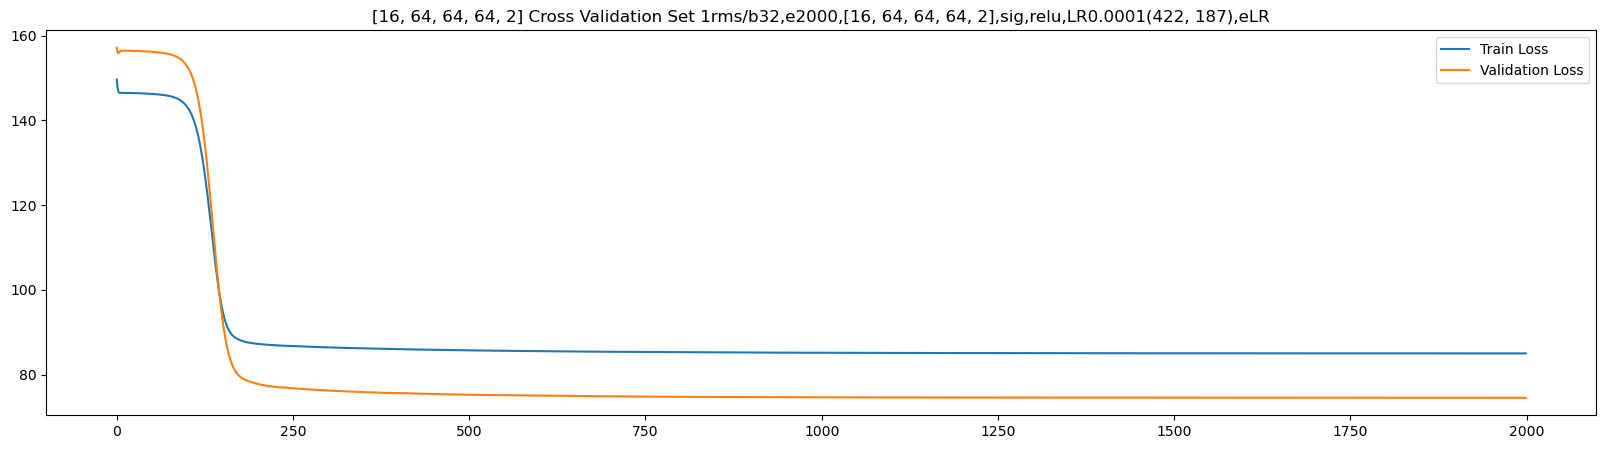

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(145, 201),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(145, 201),eLR


1999 Tr:83.25 V:79.93 Te:104.09 1563 79.9256 [2.4564991789349657e-07]: 100%|█████████████| 2000/2000 [02:14<00:00, 14.87it/s]


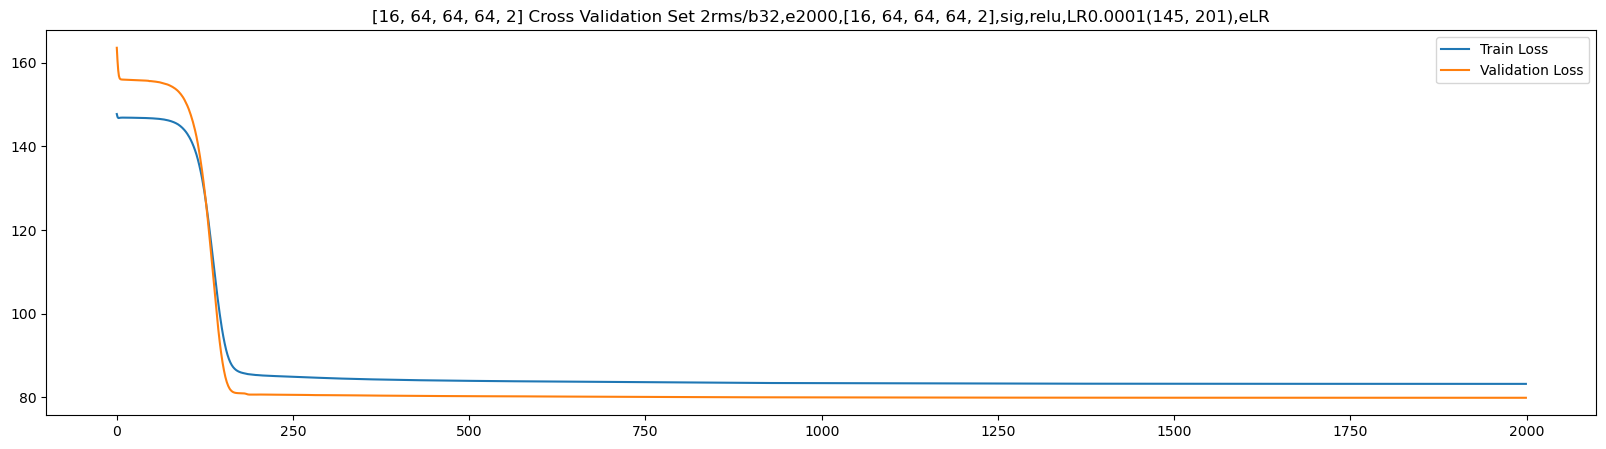

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(246, 115),eLR
models_rms/b32,e2000,[16, 64, 64, 64, 2],sig,relu,LR0.0001(246, 115),eLR


1999 Tr:79.72 V:88.24 Te:106.12 1762 88.2435 [2.4564991789349657e-07]: 100%|█████████████| 2000/2000 [02:14<00:00, 14.88it/s]


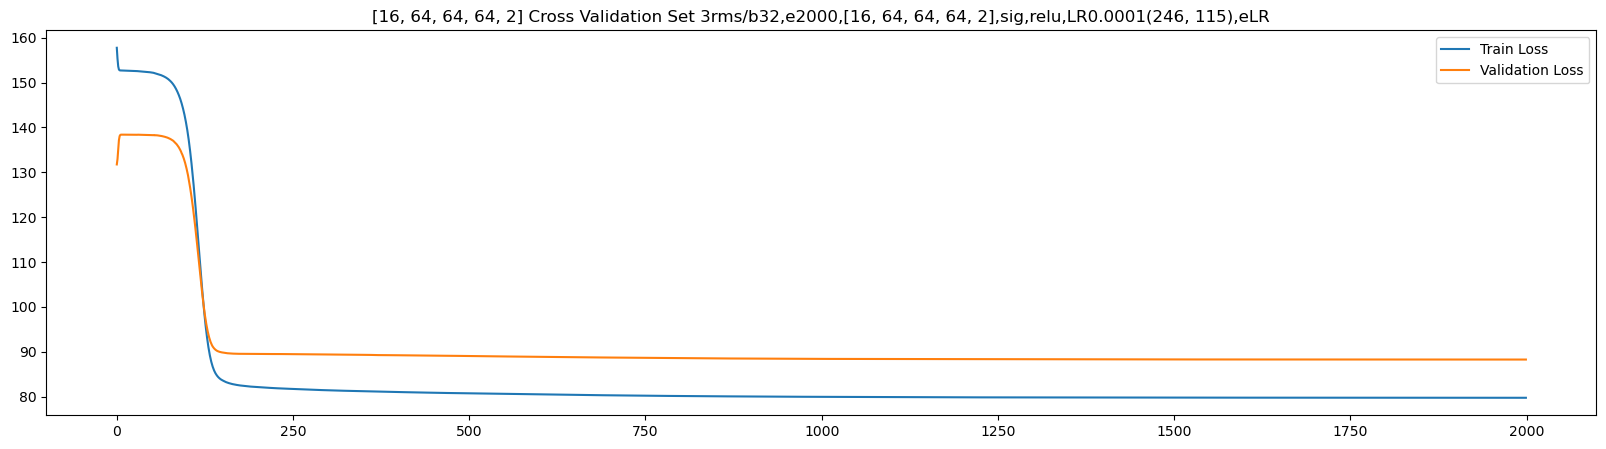

tensor(81.6732, device='cuda:0') tensor(83.8064, device='cuda:0') tensor(104.7104, device='cuda:0')


In [80]:
model = test_model(NeuralNetwork([16, 64, 64, 64, 2]), train_valid_test_sets, 
                   lr=0.0001, num_to_test=4, epochs=2000)

# 128 128 128

In [81]:
# model = test_model(NeuralNetwork([16 ,128, 128, 128, 128, 2]), train_valid_test_sets, 
#                    lr=0.1, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837])
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.01(471, 322),eLR
Using saved model 0.01 [16, 128, 128, 128, 2] tensor(43.5609, device='cuda:0') tensor(57.2966, device='cuda:0') 102     


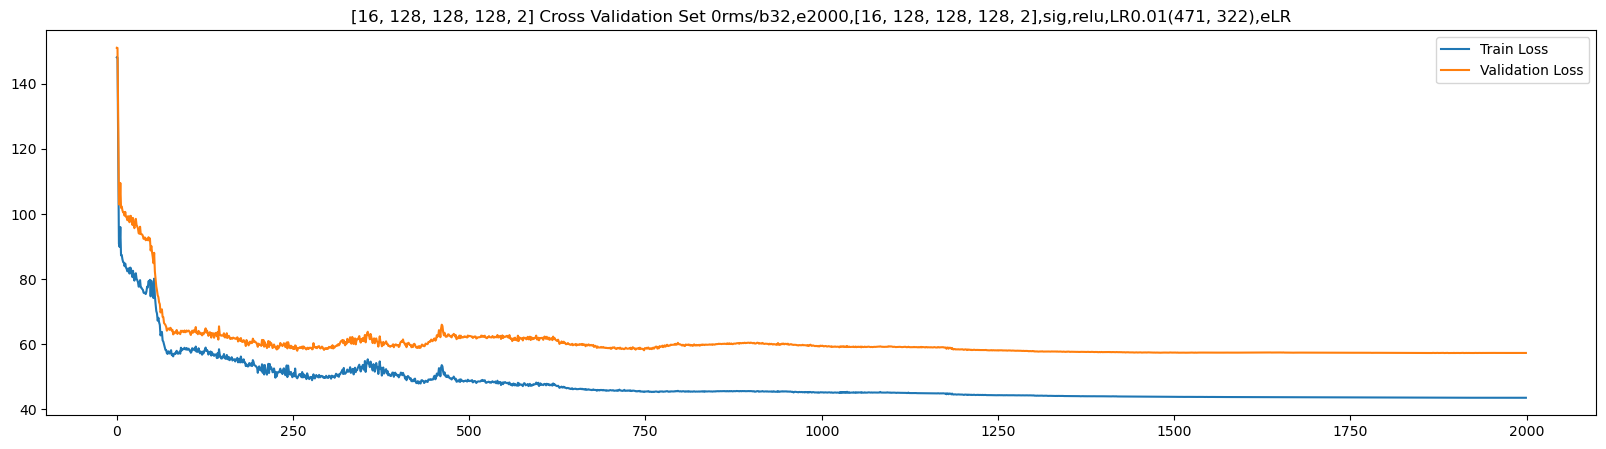

tensor([422.0765, 187.5860])
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.01(422, 187),eLR
Using saved model 0.01 [16, 128, 128, 128, 2] tensor(48.5652, device='cuda:0') tensor(54.4213, device='cuda:0') 82      


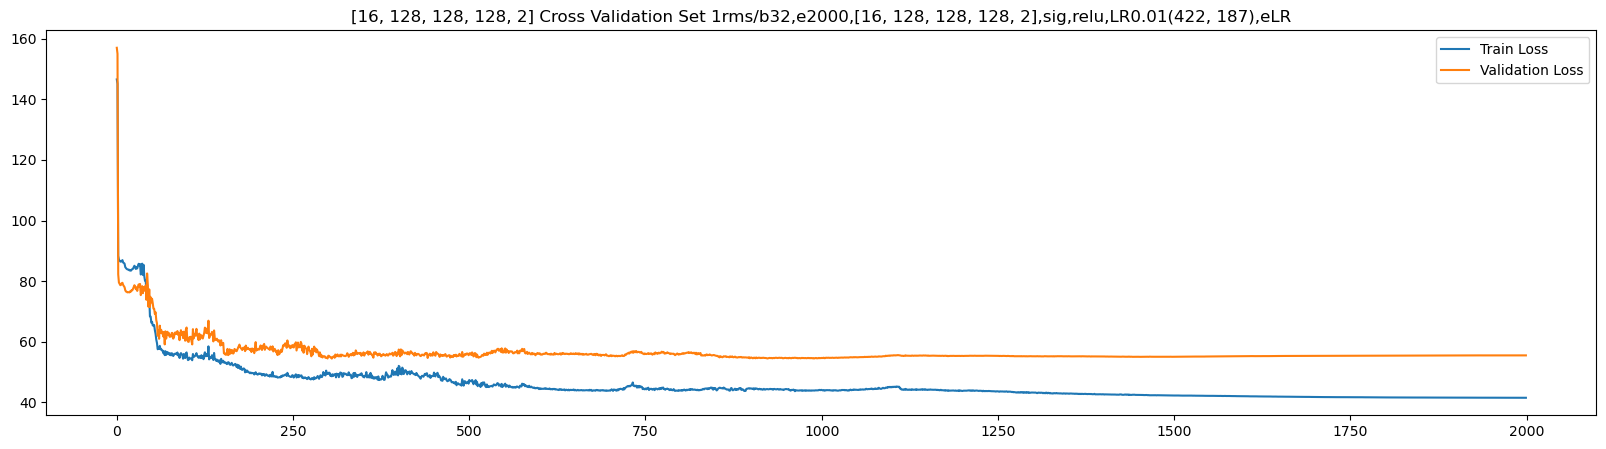

tensor([145.8423, 201.3839])
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.01(145, 201),eLR
Using saved model 0.01 [16, 128, 128, 128, 2] tensor(45.7860, device='cuda:0') tensor(54.1553, device='cuda:0') 88      


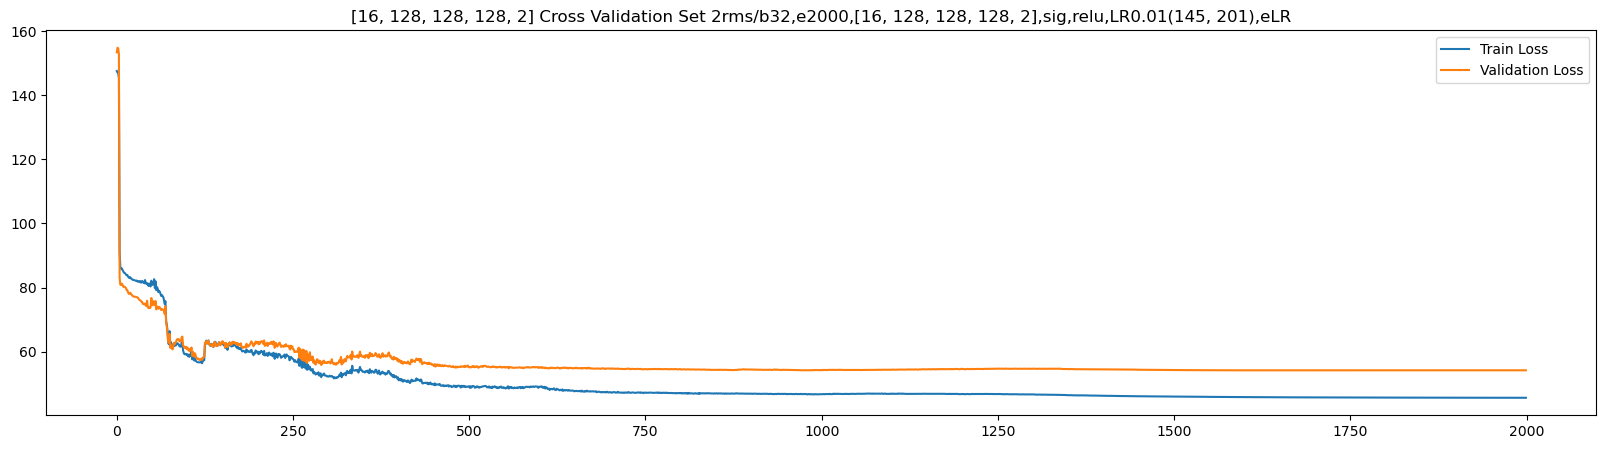

tensor([246.3203, 115.5686])
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.01(246, 115),eLR
Using saved model 0.01 [16, 128, 128, 128, 2] tensor(46.0818, device='cuda:0') tensor(55.1014, device='cuda:0') 91      


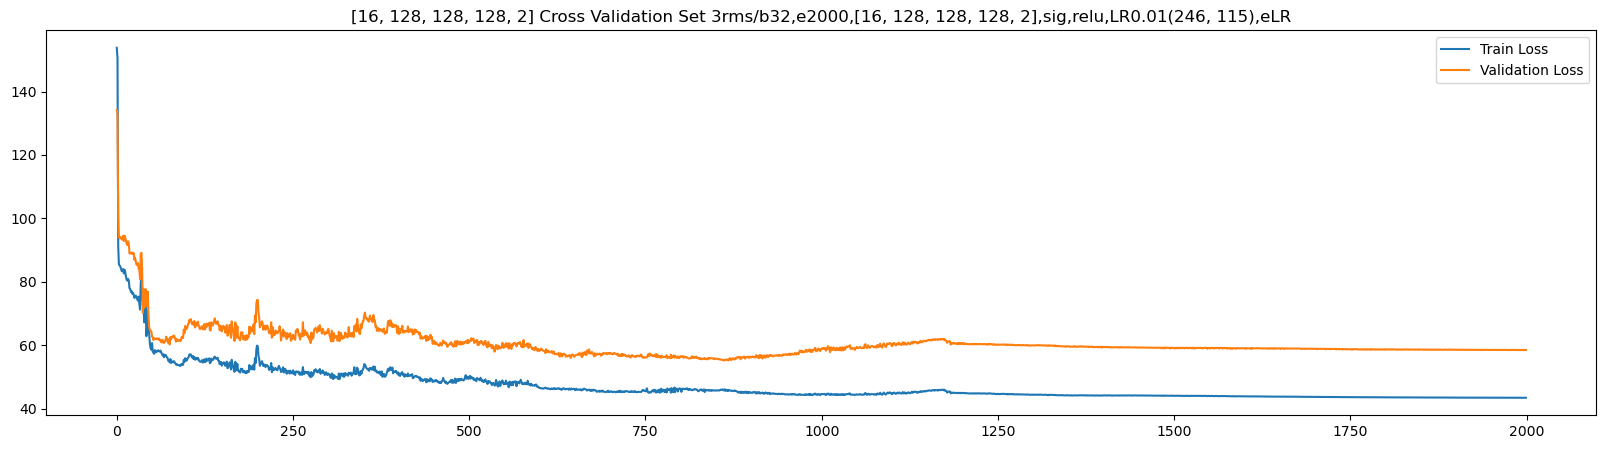

tensor(45.9985, device='cuda:0') tensor(55.2437, device='cuda:0') tensor(91.1402, device='cuda:0')


In [21]:
a=NeuralNetwork([16 ,128, 128, 128, 2])
model = test_model(NeuralNetwork([16 ,128, 128, 128, 2]), train_valid_test_sets, 
                   lr=0.01, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(471, 322),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(471, 322),eLR


1999 Tr:47.0 V:56.77 Te:85.74 478 56.7659 [2.4564991789349756e-06]: 100%|████████████████| 2000/2000 [02:09<00:00, 15.47it/s]


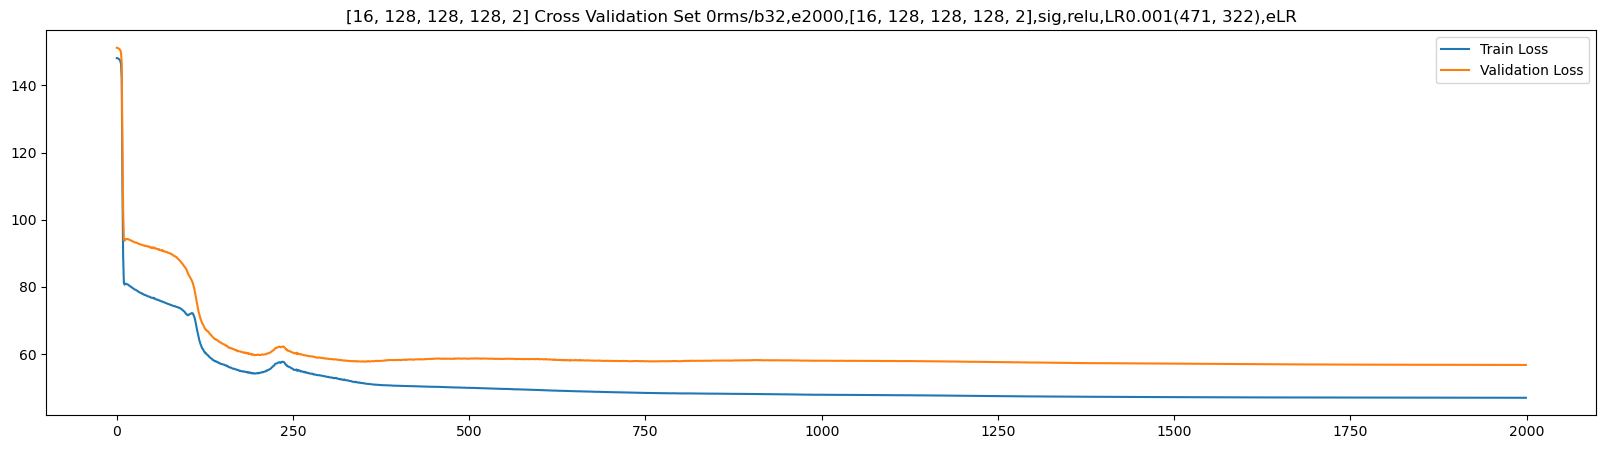

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(422, 187),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(422, 187),eLR


1999 Tr:47.09 V:54.49 Te:74.68 206 53.8255 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:08<00:00, 15.53it/s]


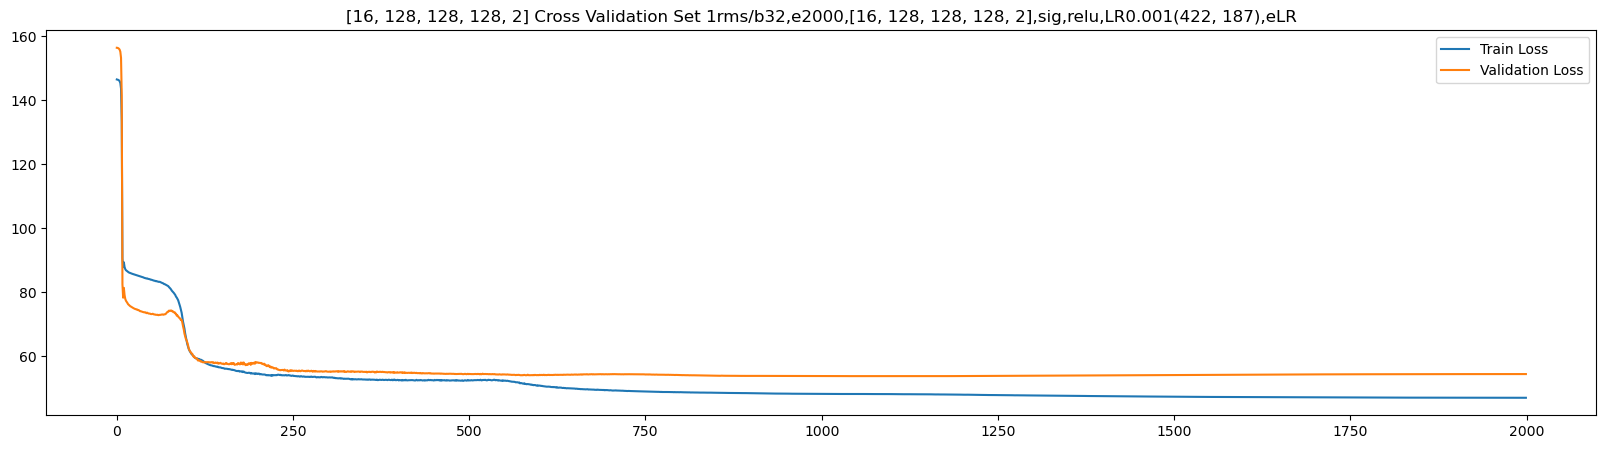

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(145, 201),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(145, 201),eLR


1999 Tr:48.85 V:54.21 Te:85.63 337 54.1802 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:09<00:00, 15.48it/s]


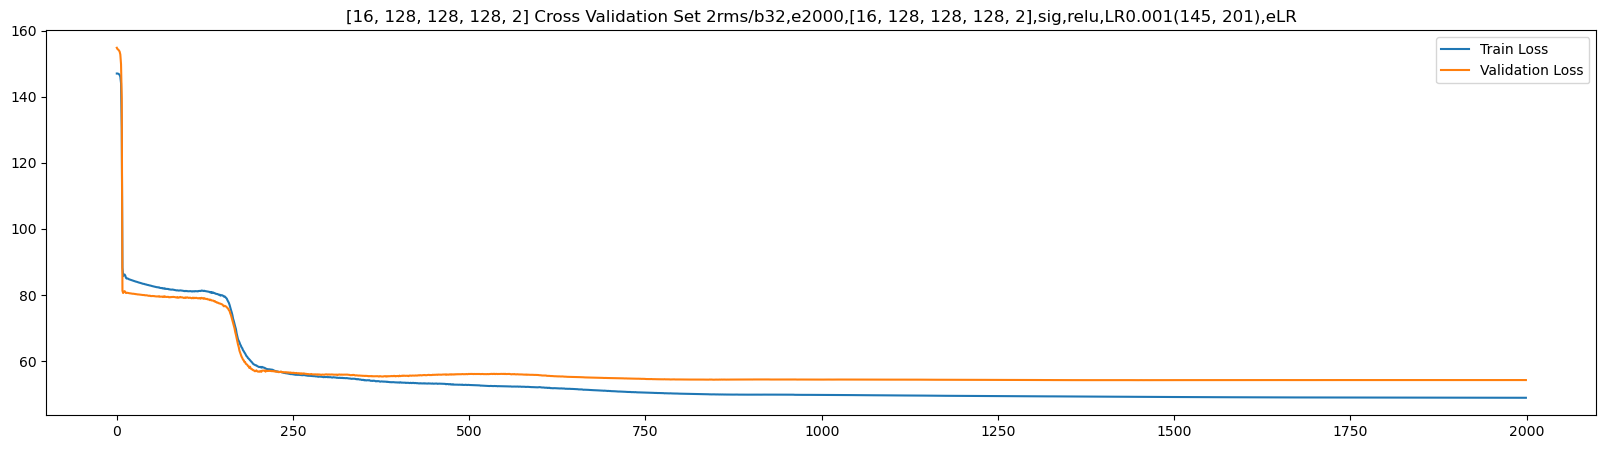

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(246, 115),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.001(246, 115),eLR


1999 Tr:48.2 V:56.9 Te:87.21 161 56.7658 [2.4564991789349756e-06]: 100%|█████████████████| 2000/2000 [02:08<00:00, 15.58it/s]


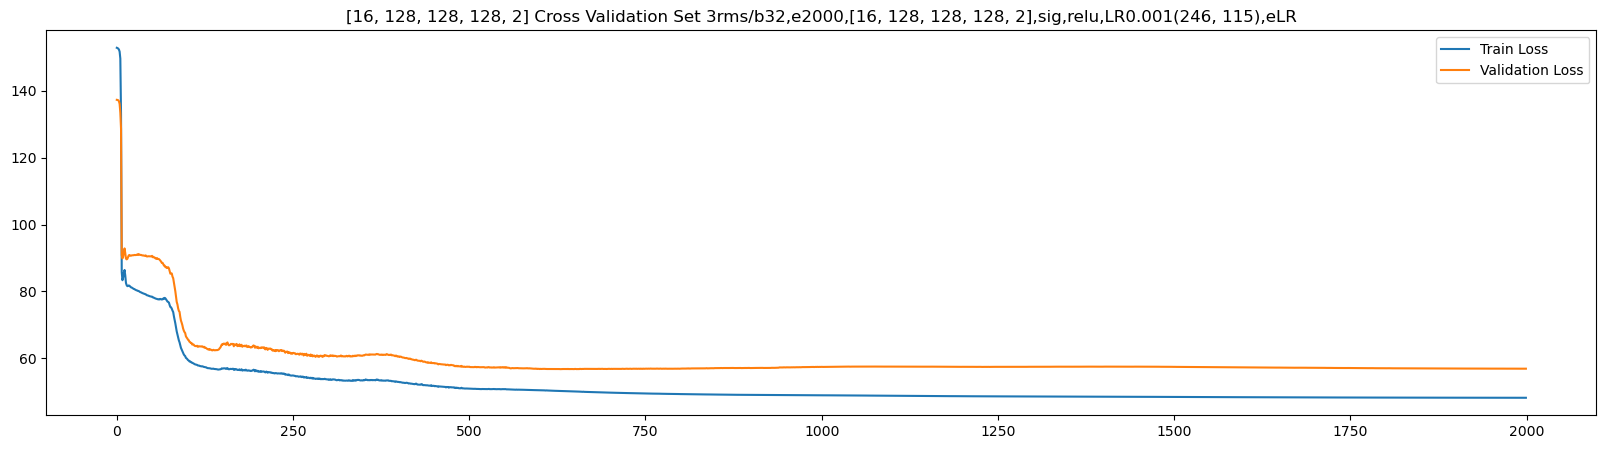

tensor(48.6540, device='cuda:0') tensor(55.3843, device='cuda:0') tensor(83.3154, device='cuda:0')


In [83]:
model = test_model(NeuralNetwork([16, 128, 128, 128, 2]), train_valid_test_sets, 
                   lr=0.001, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(471, 322),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(471, 322),eLR


1999 Tr:76.73 V:91.3 Te:107.54 1472 91.2996 [2.4564991789349657e-07]: 100%|██████████████| 2000/2000 [02:11<00:00, 15.17it/s]


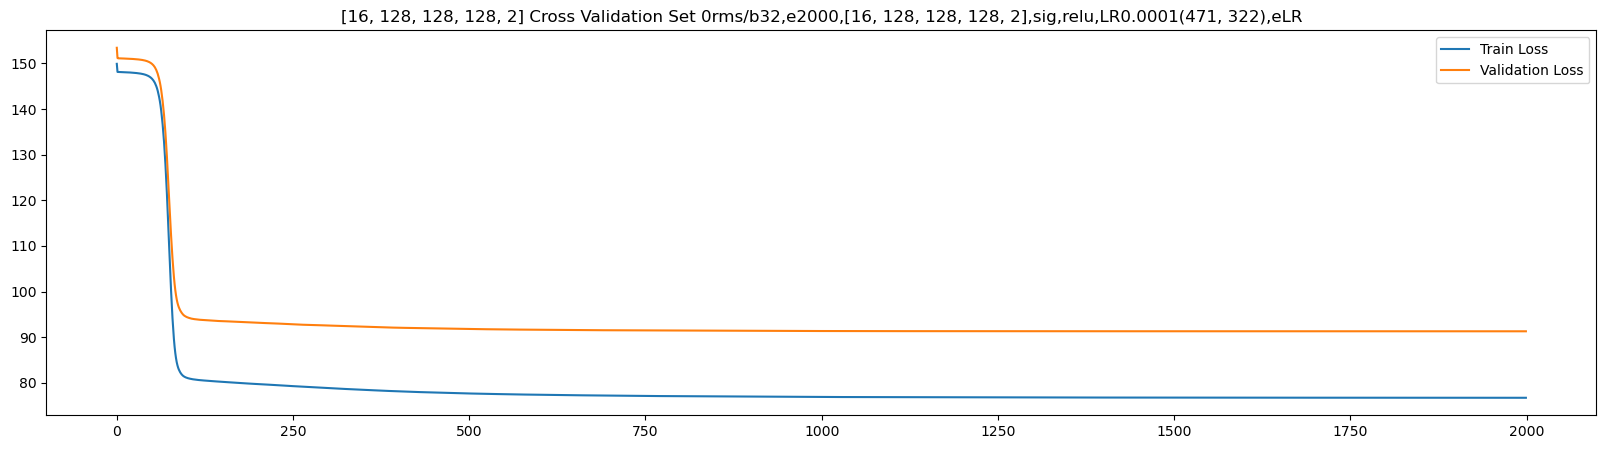

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(422, 187),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(422, 187),eLR


1999 Tr:83.85 V:73.58 Te:106.8 1119 73.5791 [2.4564991789349657e-07]: 100%|██████████████| 2000/2000 [02:11<00:00, 15.22it/s]


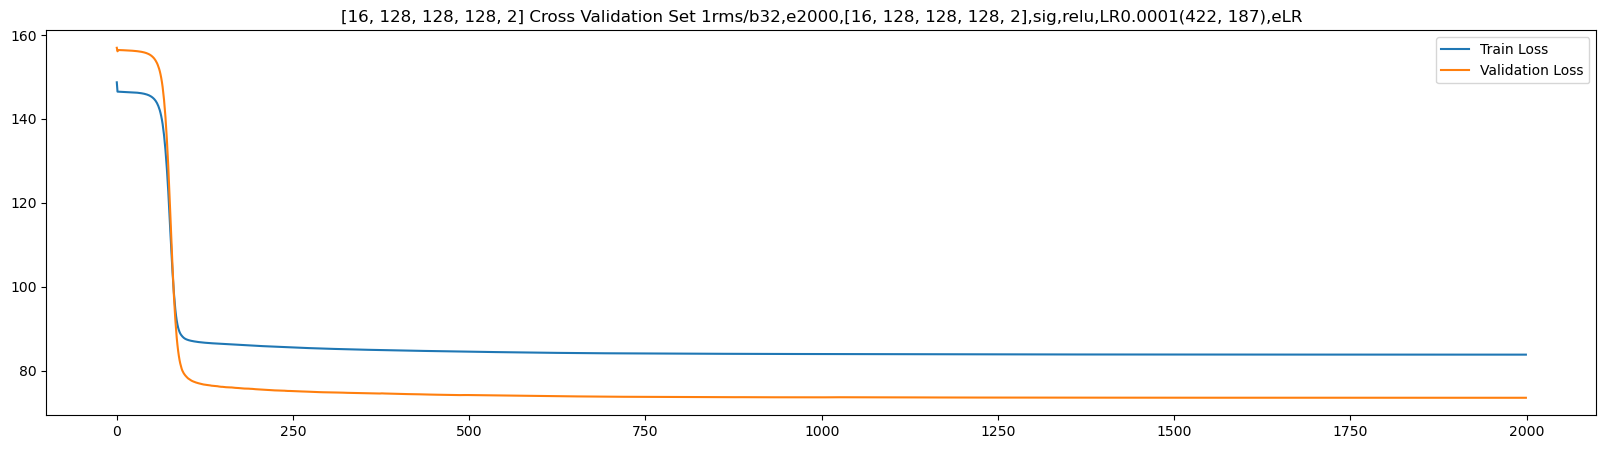

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(145, 201),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(145, 201),eLR


1999 Tr:82.08 V:79.25 Te:108.37 1039 79.2464 [2.4564991789349657e-07]: 100%|█████████████| 2000/2000 [02:11<00:00, 15.23it/s]


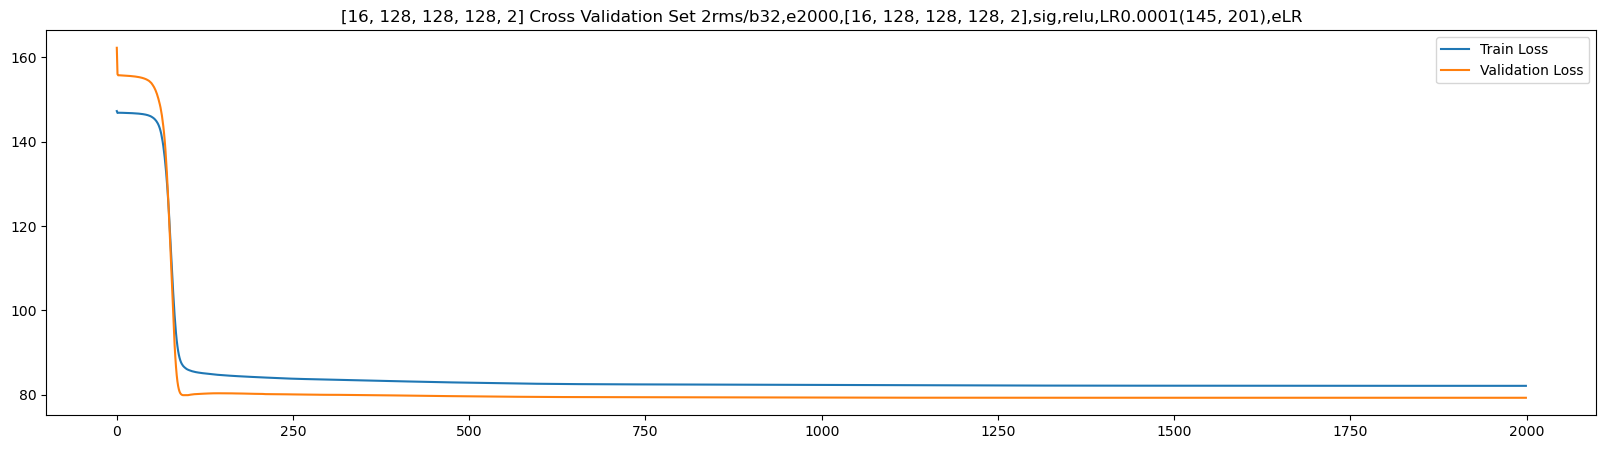

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(246, 115),eLR
models_rms/b32,e2000,[16, 128, 128, 128, 2],sig,relu,LR0.0001(246, 115),eLR


1999 Tr:77.43 V:87.95 Te:108.35 1498 87.9478 [2.4564991789349657e-07]: 100%|█████████████| 2000/2000 [02:11<00:00, 15.18it/s]


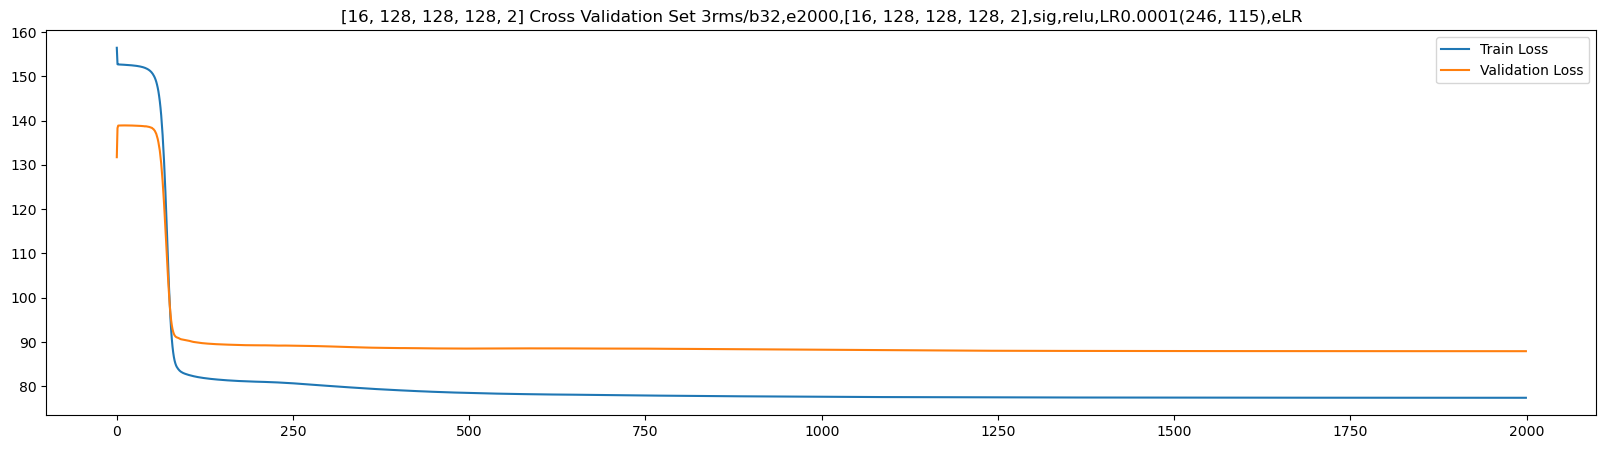

tensor(80.0249, device='cuda:0') tensor(83.0182, device='cuda:0') tensor(107.7668, device='cuda:0')


In [84]:
model = test_model(NeuralNetwork([16, 128, 128, 128, 2]), train_valid_test_sets, 
                   lr=0.0001, num_to_test=4, epochs=2000)

# 32 32 32 32

In [88]:
model = test_model(NeuralNetwork([16, 32, 32, 32, 32, 2]), train_valid_test_sets, 
                   lr=0.1, num_to_test=1, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.1(471, 322),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.1(471, 322),eLR


713 Tr:148.15 V:151.18 Te:157.51 200 151.1471 [0.01170423503947775]:  36%|█████▋          | 714/2000 [00:57<01:42, 12.49it/s]


KeyboardInterrupt: 

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(471, 322),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(471, 322),eLR


1999 Tr:48.33 V:56.34 Te:75.34 294 56.3351 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:35<00:00, 12.83it/s]


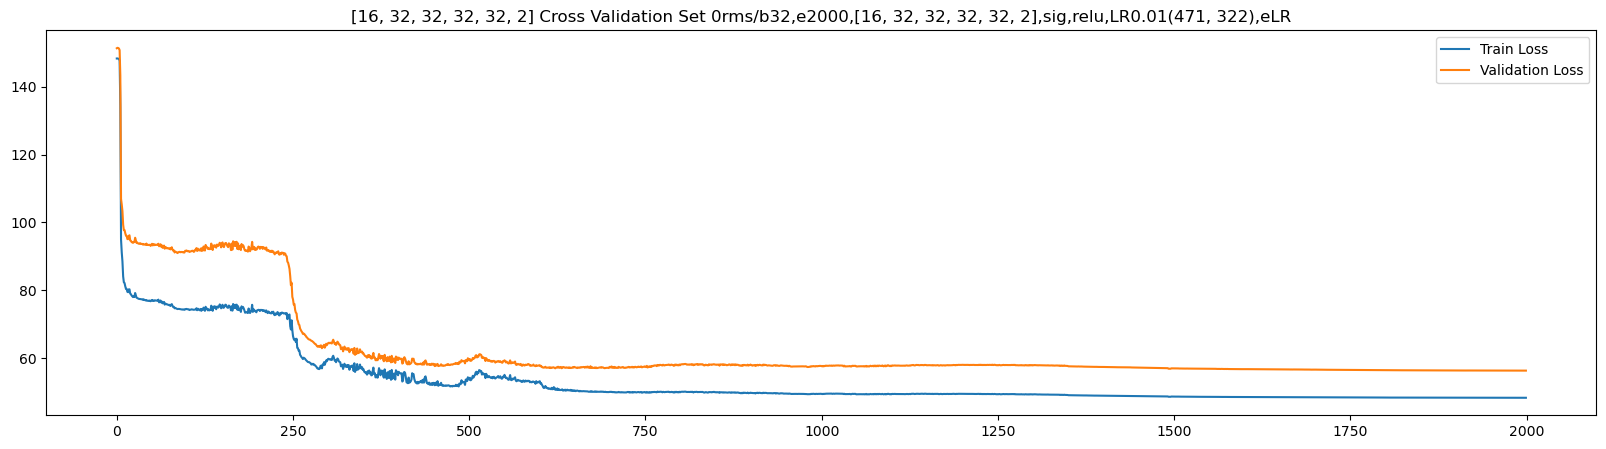

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(422, 187),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(422, 187),eLR


1999 Tr:45.84 V:54.7 Te:70.1 71 53.4348 [2.456499178934972e-05]: 100%|███████████████████| 2000/2000 [02:36<00:00, 12.77it/s]


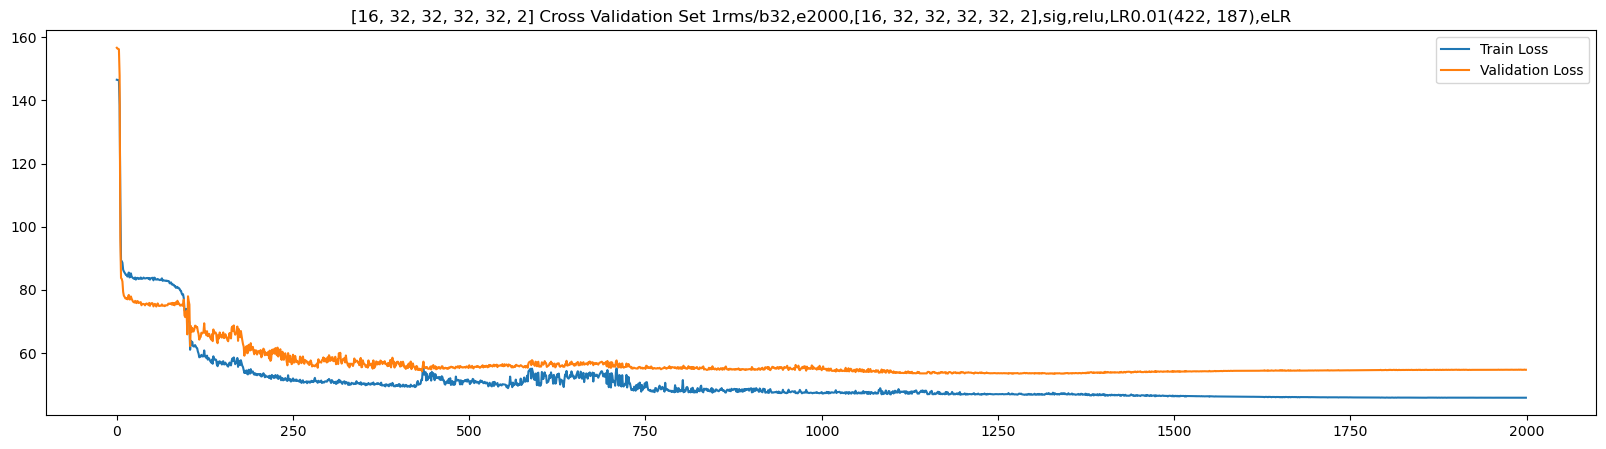

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(145, 201),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(145, 201),eLR


1999 Tr:54.29 V:56.77 Te:73.32 143 56.1443 [2.456499178934972e-05]: 100%|████████████████| 2000/2000 [02:36<00:00, 12.75it/s]


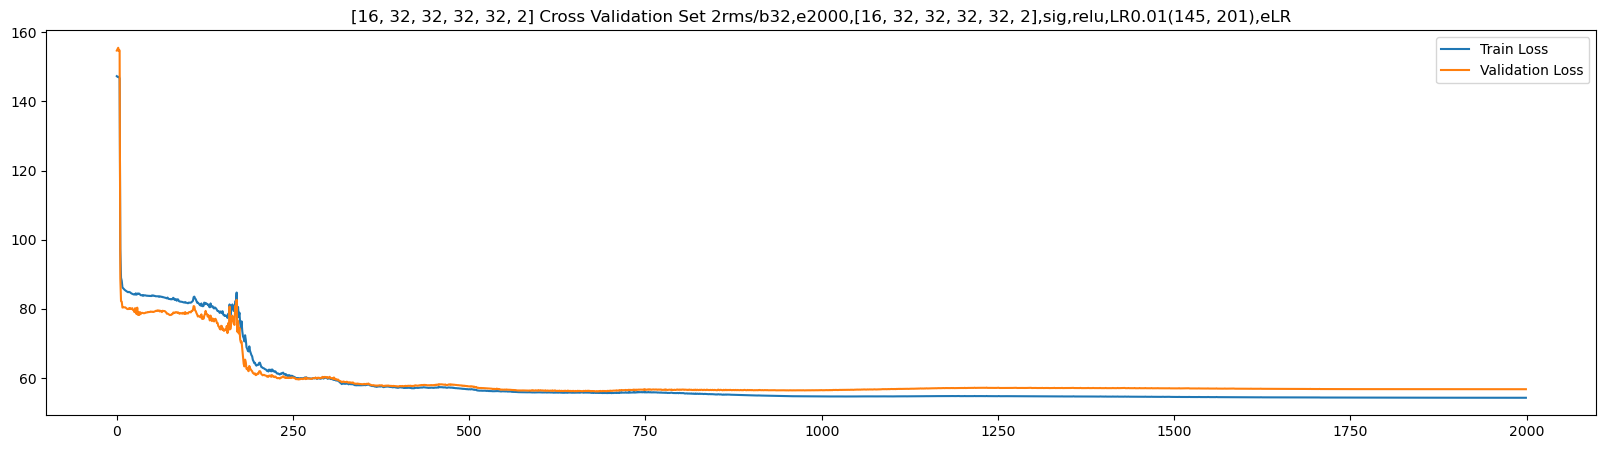

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(246, 115),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.01(246, 115),eLR


1999 Tr:46.35 V:56.57 Te:79.31 68 55.2467 [2.456499178934972e-05]: 100%|█████████████████| 2000/2000 [02:36<00:00, 12.81it/s]


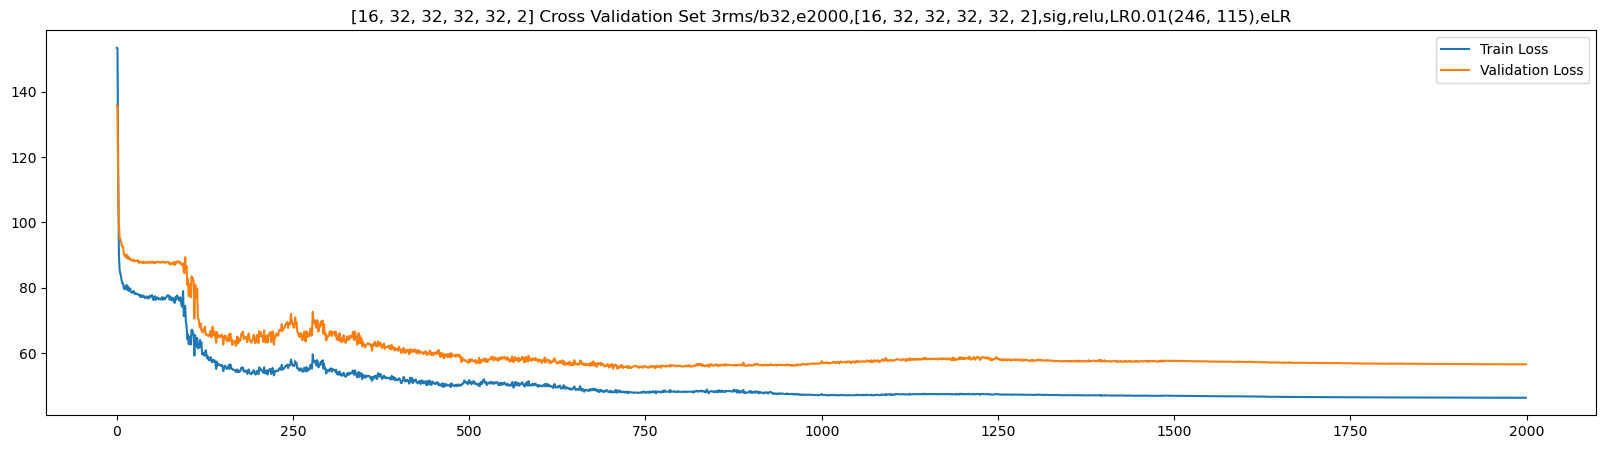

tensor(49.8400, device='cuda:0') tensor(55.2903, device='cuda:0') tensor(74.5160, device='cuda:0')


In [85]:
model = test_model(NeuralNetwork([16, 32, 32, 32, 32, 2]), train_valid_test_sets, 
                   lr=0.01, num_to_test=4, epochs=2000)

tensor([471.4490, 322.5837], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(471, 322),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(471, 322),eLR


1999 Tr:73.21 V:89.58 Te:106.45 467 89.5837 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:35<00:00, 12.87it/s]


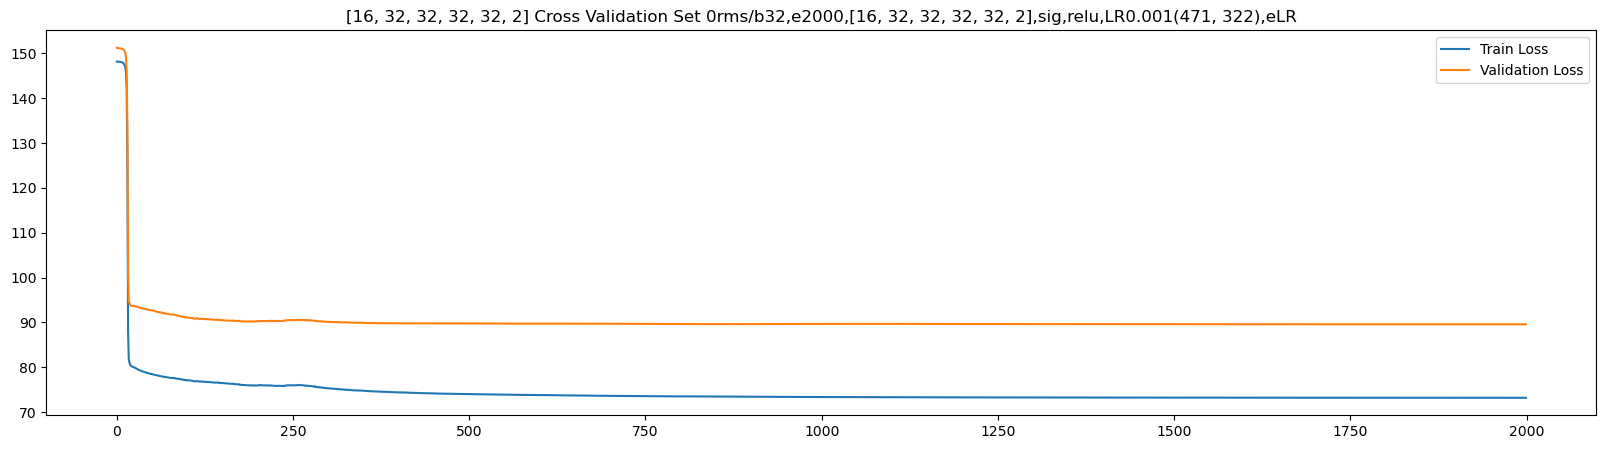

tensor([422.0765, 187.5860], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(422, 187),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(422, 187),eLR


1999 Tr:83.61 V:72.99 Te:100.38 401 72.8704 [2.4564991789349756e-06]: 100%|██████████████| 2000/2000 [02:38<00:00, 12.63it/s]


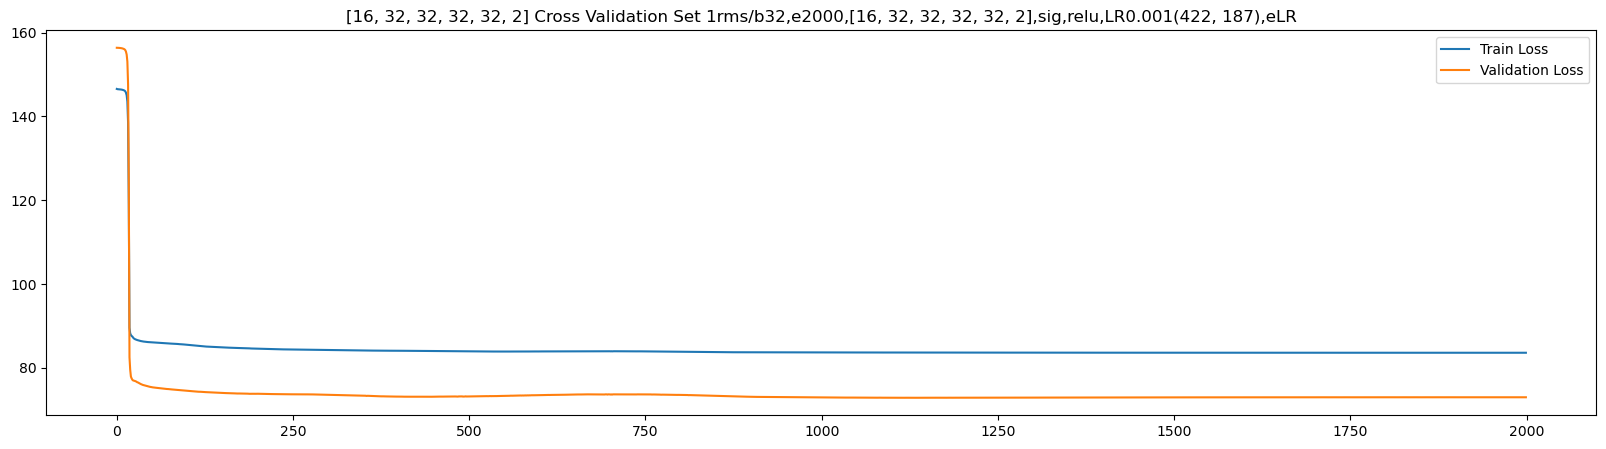

tensor([145.8423, 201.3839], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(145, 201),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(145, 201),eLR


1999 Tr:82.31 V:80.51 Te:103.56 57 79.3377 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:33<00:00, 13.00it/s]


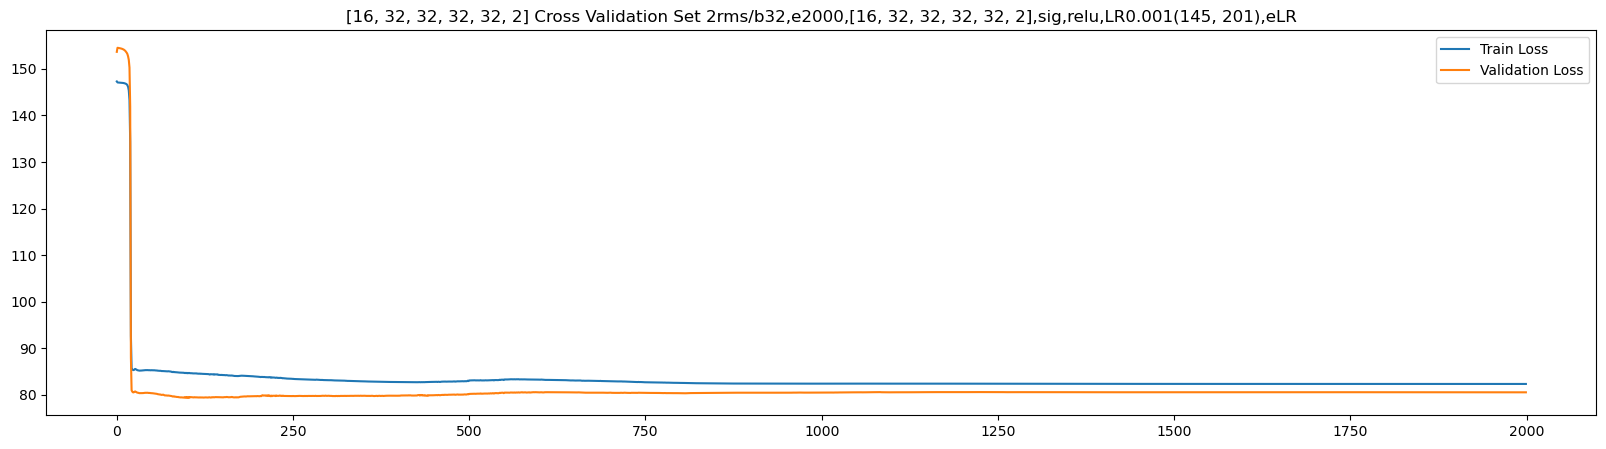

tensor([246.3203, 115.5686], device='cuda:0')
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(246, 115),eLR
models_rms/b32,e2000,[16, 32, 32, 32, 32, 2],sig,relu,LR0.001(246, 115),eLR


1999 Tr:76.09 V:89.2 Te:100.96 901 89.2048 [2.4564991789349756e-06]: 100%|███████████████| 2000/2000 [02:39<00:00, 12.50it/s]


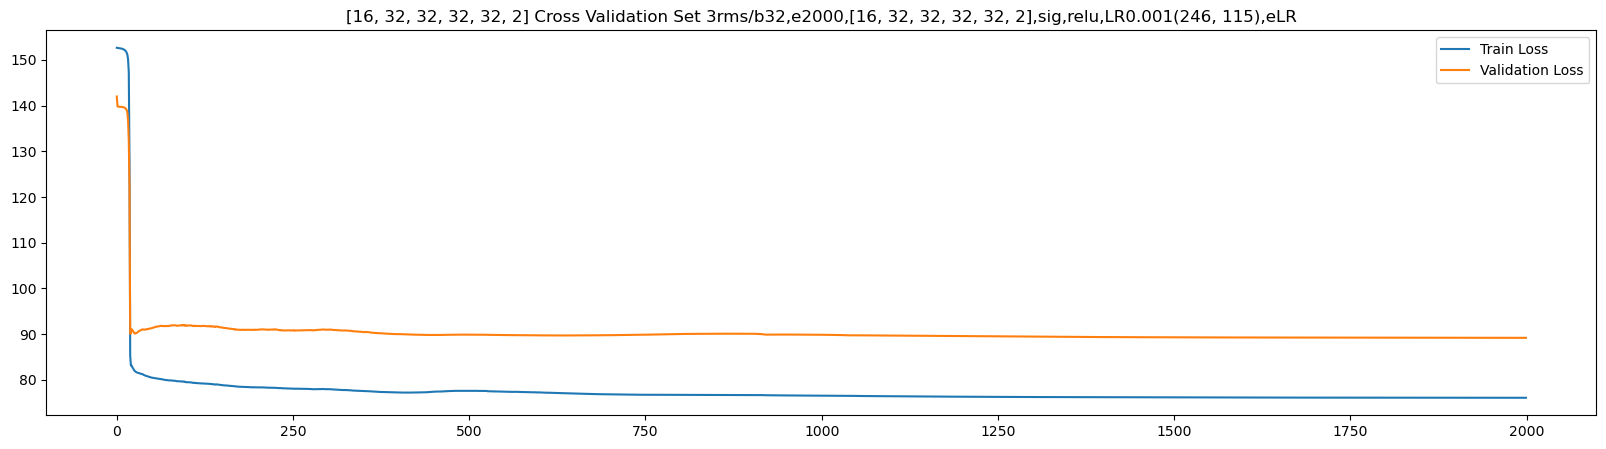

tensor(79.4136, device='cuda:0') tensor(82.7492, device='cuda:0') tensor(102.8399, device='cuda:0')


In [86]:
model = test_model(NeuralNetwork([16, 32, 32, 32, 32, 2]), train_valid_test_sets, 
                   lr=0.001, num_to_test=4, epochs=2000)

# Final Test

In [47]:
def final_train_model(model, data, batch_size=32, epochs=200, parameters="final", saving="", 
                shuffle_data=True, save=False, verbose=True, lr=0.01, final=False):
    random.seed(1)
    X_train, Y_train, X_val, Y_val, X_tests, Y_tests = data
    print(X_train.shape, X_val.shape)
    model=model.cuda()
    X_train = torch.vstack([X_train, X_val]).cuda()
    Y_train = torch.vstack([Y_train, Y_val]).cuda()
    X_tests = [i.cuda() for i in X_tests]
    Y_tests = [i.cuda() for i in Y_tests]
    test_loss_list = [[] for i in range(len(X_tests))]
    
    train_losses=[]
    
    sig = "sig" if model.sigmoid_vars is not None else ""
    relu = "relu" if model.use_relu else ""
    # print(sch)
    parameters = f"models_rms/b{batch_size},e{epochs},{model.layer_sizes},{sig},{relu},LR{str(lr)}{(int(Y_val[0, 0].item()), int(Y_val[0, 1].item()))}" + parameters
    print(parameters)

    if shuffle_data:
        perm=[i for i in range(len(X_train))]
        random.shuffle(perm)
        X_train, Y_train = X_train[perm], Y_train[perm]

    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.997)
    
    pbar = tqdm(range(epochs), ncols=125)
    loss = nn.MSELoss()
    for epoch in pbar:
        for batch in range(len(X_train) // batch_size):
            model.train()
            optimizer.zero_grad()
            outputs_train = model(X_train[batch_size * batch: batch_size * (batch + 1)])
            
            batch_train_loss = loss(outputs_train, Y_train[batch_size * batch: batch_size * (batch + 1)])
            batch_train_loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            train_loss = mae_loss(model(X_train), Y_train)
            for i in range(len(X_tests)):
                curr_test_loss = mae_loss(model(X_tests[i]), Y_tests[i])
                test_loss_list[i].append(curr_test_loss.detach().cpu().item())
        train_losses.append(train_loss.detach().cpu().item())
        scheduler.step()
        pbar.set_description(str(epoch) +" Tr:"+ str(round(train_loss.item(), 2)) + str([round(test_loss_list[i][-1], 2) for i in range(len(X_tests))]))
    plt.plot(train_losses)
    plt.show()
    return model, train_losses, test_loss_list


In [44]:
model = NeuralNetwork([16, 32, 32, 32, 2])
X_train, Y_train, X_val, Y_val, X_test, Y_test = train_valid_test_sets[0]

In [45]:
X_train.cpu()
a = torch.vstack((torch.rand(X_train.shape), torch.rand(X_val.shape)))
a

tensor([[0.1942, 0.0638, 0.7049,  ..., 0.1894, 0.8246, 0.4974],
        [0.6680, 0.7425, 0.4829,  ..., 0.4051, 0.0798, 0.9410],
        [0.8913, 0.6885, 0.2819,  ..., 0.1628, 0.7835, 0.4955],
        ...,
        [0.2072, 0.8932, 0.1746,  ..., 0.3922, 0.9466, 0.0026],
        [0.4967, 0.8219, 0.8878,  ..., 0.3632, 0.2138, 0.2335],
        [0.6914, 0.5228, 0.8638,  ..., 0.7680, 0.0459, 0.0714]])

-1
torch.Size([2415, 16]) torch.Size([805, 16])
models_rms/b32,e2000,[16, 32, 32, 32, 2],sig,relu,LR0.01(471, 322)final


1999 Tr:45.44[40.64, 37.68, 40.55, 47.15, 45.86, 51.17, 58.68, 76.34, 200.96, 284.77]: 100%|█| 2000/2000 [06:22<00:00,  5.23i


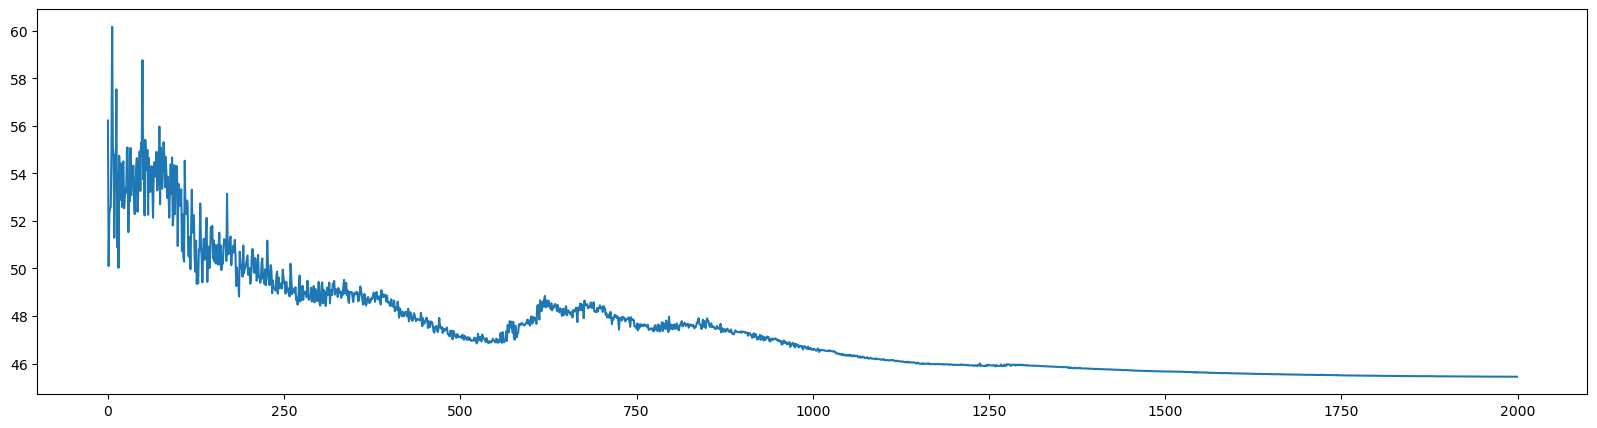

In [48]:


print(X_train.get_device())

model, train_losses, test_loss_list=final_train_model(model, (X_train, Y_train, X_val, Y_val, X_test_sets, Y_test_sets), lr=0.01, epochs=2000)

Bin 10: 284.77117919921875
Bin 9: 200.96263122558594
Bin 8: 76.34175872802734
Bin 7: 58.682640075683594
Bin 6: 51.16851806640625
Bin 5: 45.85928726196289
Bin 4: 47.149295806884766
Bin 3: 40.547821044921875
Bin 2: 37.677371978759766
Bin 1: 40.64150619506836
88.38020095825195


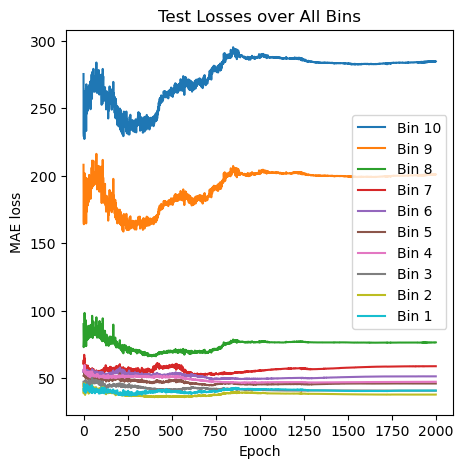

Bin 7: 58.682640075683594
Bin 6: 51.16851806640625
Bin 5: 45.85928726196289
Bin 4: 47.149295806884766
Bin 3: 40.547821044921875
Bin 2: 37.677371978759766
Bin 1: 40.64150619506836
32.17264404296875


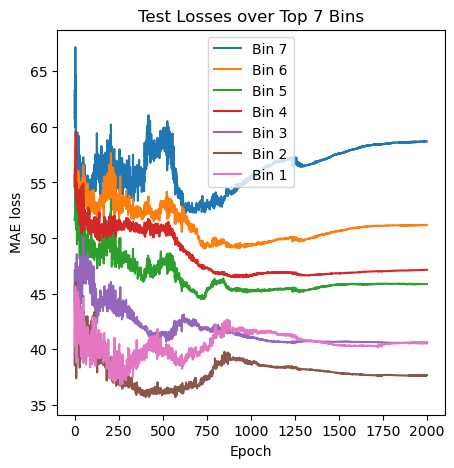

Final all test loss 88.38020095825195


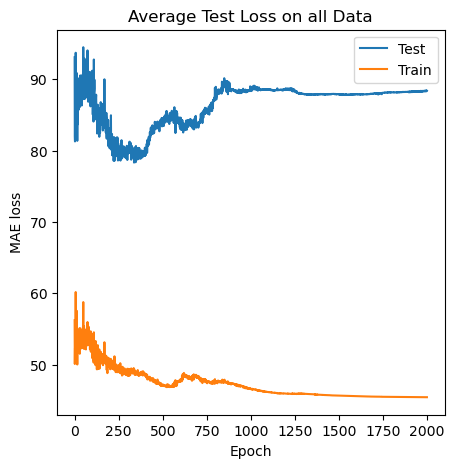

torch.return_types.sort(
values=tensor([78.3103, 78.3603, 78.5589,  ..., 93.6954, 94.0257, 94.4713]),
indices=tensor([337, 346, 226,  ...,   6,  73,  49]))
Final 7 test loss 45.96092006138393
Final train loss 45.44390106201172
torch.return_types.sort(
values=tensor([78.3103, 78.3603, 78.5589,  ..., 93.6954, 94.0257, 94.4713]),
indices=tensor([337, 346, 226,  ...,   6,  73,  49]))


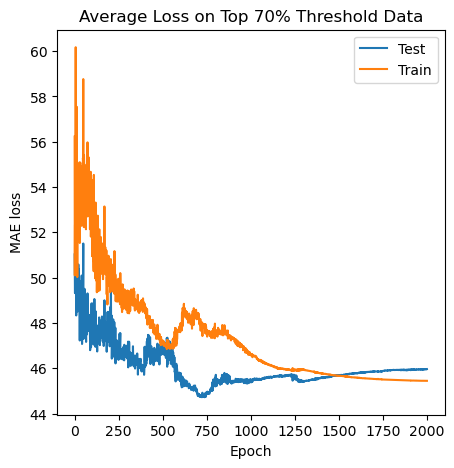

In [18]:
# torch.save((train_losses, test_loss_list), "models_rms/final_results_rms.pt")
train_losses, test_loss_list=torch.load("models_rms/final_results_rms.pt")
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]
# plt.plot(train_losses[:2000], label="Train Loss")
average = 0.0
for i, loss in reversed(list(enumerate(test_loss_list))):
    print(f"Bin {i+1}: {loss[-1]}")
    average+= loss[-1] / 10
    plt.plot(loss[:2000], label=f"Bin {i+1}")

print(average)
plt.title("Test Losses over All Bins")
plt.legend()
plt.ylabel("MAE loss")
plt.xlabel("Epoch")
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
# plt.plot(train_losses[:2000], label="Train Loss")
average = 0.0
for i, loss in reversed(list(enumerate(test_loss_list[:7]))):
    print(f"Bin {i+1}: {loss[-1]}")
    average+= loss[-1] / 10
    plt.plot(loss[:2000], label=f"Bin {i+1}")

print(average)
plt.title("Test Losses over Top 7 Bins")
plt.legend()
plt.ylabel("MAE loss")
plt.xlabel("Epoch")
plt.show()

all_loss = []
for i in range(2000):
    average = 0.0
    for loss in test_loss_list:
        average+=loss[i]/10
    all_loss.append(average)
plt.title("Average Test Loss on all Data")
plt.plot(all_loss, label="Test")
print("Final all test loss", all_loss[-1])
plt.plot(train_losses, label="Train")
plt.legend()
plt.ylabel("MAE loss")
plt.xlabel("Epoch")

plt.show()
print(torch.tensor(all_loss).sort())

all_loss7 = []
for i in range(2000):
    average = 0.0
    for loss in test_loss_list[:7]:
        average+=loss[i]/7
    all_loss7.append(average)
plt.title("Average Loss on Top 70% Threshold Data")
plt.plot(all_loss7, label="Test")
print("Final 7 test loss", all_loss7[-1])
print("Final train loss", train_losses[-1])
plt.plot(train_losses, label="Train")
plt.legend()
plt.ylabel("MAE loss")
plt.xlabel("Epoch")
print(torch.tensor(all_loss).sort())
plt.show()